# AMS 595 Group Project: Identifying Risk Factors for Major Depressive Disorder

### Abby Bindelglass, Jane Condon, Nicholas Tardugno, Sydney Walters-Diaz

## Data Preparation

In [3]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


### Importing Necessary Libraries

In [5]:
!pip install --upgrade statsmodels

In [6]:
!pip install lightgbm

In [7]:
# Insert libraries here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay,
    classification_report, brier_score_loss
)
from sklearn.calibration import calibration_curve
import lightgbm as lgb
from catboost import CatBoostClassifier
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Importing the Data

In [9]:
# Reading the dataset into python using pandas
df = pd.read_csv("mhcld_puf_2023.csv", low_memory=False)

In [10]:
# Looking at the first few rows to ensure that the data has been imported correctly
df.head()

,YEAR,AGE,EDUC,ETHNIC,RACE,SEX,SPHSERVICE,CMPSERVICE,OPISERVICE,RTCSERVICE,...,ODDFLG,PDDFLG,PERSONFLG,SCHIZOFLG,ALCSUBFLG,OTHERDISFLG,STATEFIP,DIVISION,REGION,CASEID
0,2023,4,-9,3,5,2,2,1,1,2,...,0,0,0,0,0,0,1,6,3,20230000001
1,2023,5,4,4,3,2,1,2,2,2,...,0,0,0,1,0,0,1,6,3,20230000002
2,2023,8,4,4,5,2,1,1,2,2,...,0,0,0,1,0,0,1,6,3,20230000003
3,2023,11,-9,3,5,2,2,1,2,2,...,0,0,0,0,0,1,1,6,3,20230000004
4,2023,3,3,4,5,2,1,1,2,2,...,0,0,0,0,0,0,1,6,3,20230000005


### Data Preprocessing

#### Mapping For Easier Readability

As shown above, the readability of the data is very poor, as is often seen with large survey data. To make the data easier to interpret and understand, we will map our variables to the values/explanations provided in the codebook. We will start with the target variable, "DEPRESSFLG".

In [14]:
# Target variable: depressive disorder variable map

depressflg_map = {
    1: "Depressive disorder reported",
    0: "Not reported"
}


We can also map the predictor variables into something that is easier to understand. We start with the co-occurring mental health disorder variables. Since the values have the same meaning for each of the variables, (i.e., 0 = disorder reported, 1 = disorder not reported), we can combine them into a single map.

In [16]:
# Predictor map: co-occurring mental health disorders map

disorder_flags = ["ANXIETYFLG", "ADHDFLG", "CONDUCTFLG", "DELIRDEMFLG", "BIPOLARFLG",
         "ODDFLG", "PDDFLG", "PERSONFLG", "SCHIZOFLG", "OTHERDISFLG",
         "TRAUSTREFLG", "ALCSUBFLG"]

binary_flag_map = {1: "Reported", 0: "Not reported"}

For our next predictor variable, substance use disorder, we have two variables that we may use:

* SAP (binary): Gives a value of 1 if substance use disorder present, 2 if substance use disorder not present, and 0 if the response to this survey question is missing.
* SUB (numeric): Gives a value of 1-13 indicating a client's substance use diagnosis during the reporting period (e.g., 9 = alcohol abuse, 10 = cocaine abuse), or a value of -9 for a missing/invalid diagnosis.

Since the category codes of these variables are different from those of the co-occurring mental health disorder variables and are NOT binary, we must create a separate map. We can use the SAP variable to construct a simple yes/no variable indicating whether or not a survey respondent has been diagnosed with any type of substance use disorder. If we want to look into this further, the SUB variable indicates WHICH substance use disorder an individual has been diagnosed with.

In [18]:
# Predictor map: substance use map (SUB)

sub_use_map = {
    1: "Trauma/stressor disorder",
    2: "Anxiety disorder",
    3: "Attention deficit/hyperactivity disorder (ADHD)",
    4: "Conduct disorder",
    5: "Delirium/dementia disorder",
    6: "Bipolar disorder",
    7: "Depressive disorder",
    8: "Oppositional defiant disorder",
    9: "Pervasive developmental disorder",
    10: "Personality disorder",
    11: "Schizophrenia/psychotic disorder",
    12: "Alcohol or Substance Use Disorder",
    13: "Other disorder",
    -9: "Missing",
    -8: "Not applicable"
}


In [19]:
# Predictor map: substance use map (SAP)
sap_map = {
    1: "Substance use problem reported",
    0: "No substance use problem reported",
    -9: "Missing",
    -8: "Not applicable"
}

# Applying to SAP column:
df["SAP_LABEL"] = df["SAP"].map(sap_map)

# Creating into a simple yes/no binary variable
df["HAS_SAP"] = df["SAP"].isin([1]).astype(int)

Some other useful predictor variables that we can map are age, sex, education status, marital status, residential status, veteran status, employment status, race/ethnicity, and geographic region (in the U.S.).

In [21]:
# Predictor map: age

age_map = {
    1: "0–11",
    2: "12–14",
    3: "15–17",
    4: "18–20",
    5: "21–24",
    6: "25–29",
    7: "30–34",
    8: "35–39",
    9: "40–44",
    10: "45–49",
    11: "50–54",
    12: "55–59",
    13: "60–64",
    14: "65+",
    -9: "Missing",
    -8: "Not applicable"
}


In [22]:
# Predictor map: sex
sex_map = {
    1: "Male",
    2: "Female",
    -9: "Missing",
    -8: "Not applicable"
}


In [23]:
# Predictor map: education level
educ_map = {
    1: "Special education",
    2: "8 years or less",
    3: "9–11 years",
    4: "12 years or GED",
    5: "13 years or more",
    -9: "Missing",
    -8: "Not applicable"
}


In [24]:
# Predictor map: marital status
marstat_map = {
    1: "Never married",
    2: "Now married",
    3: "Separated",
    4: "Divorced or widowed",
    -9: "Missing",
    -8: "Not applicable"
}


In [25]:
# Predictor map: residential status
livarag_map = {
    1: "Experiencing homelessness",
    2: "Private residence",
    3: "Other",
    -9: "Missing",
    -8: "Not applicable"
}


In [26]:
# Predictor map: veteran status
veteran_map = {
    1: "Veteran",
    2: "Not a veteran",
    -9: "Missing",
    -8: "Not applicable"
}


In [27]:
# Predictor map: employment status
employ_map = {
    1: "Full-time",
    2: "Part-time",
    3: "Employed (not differentiated)",
    4: "Unemployed",
    5: "Not in labor force",
    -9: "Missing",
    -8: "Not applicable"
}

In [28]:
# Predictor map: ethnicity
ethnic_map = {
    1: "Hispanic or Latino",
    2: "Not Hispanic or Latino",
    -9: "Missing",
    -8: "Not applicable"
}

In [29]:
# Predictor map: race
race_map = {
    1: "White",
    2: "Black or African American",
    3: "American Indian or Alaska Native",
    4: "Asian",
    5: "Native Hawaiian or Pacific Islander",
    6: "Multiracial",
    -9: "Missing",
    -8: "Not applicable"
}

In [30]:
region_map = {
    1: "Northeast",
    2: "Midwest",
    3: "South",
    4: "West"
}

#### Creating a Pre-Processing Function

Next, we can create a pre-processing function that:
* Applies every mapping dictionary to the dataframe
* Creates binary flags (simple yes/no variable for appropriate variables)
* Handles missing values (using median/mode imputation)
* Returns a numeric dataframe for modeling, as well as a labeled dataframe that is easier to read/interpret

In [33]:
def preprocess_data(df):

    # Dealing with missing SAMHSA codes
    missing_codes = [-9, -8, -7, -6]
    df = df.replace(missing_codes, np.nan)

    # Preserving disorder flags as numeric
    for f in disorder_flags:
        if f in df.columns:
            df[f] = df[f].fillna(0).astype(int)

    # Preserving SUB and SAP as numeric predictors
    if "SUB" in df.columns:
        df["SUB"] = df["SUB"].fillna(0).astype(int)
    if "SAP" in df.columns:
        df["SAP"] = df["SAP"].fillna(0).astype(int)

    # Dropping unnecessary columns
    id_cols = ["CASEID", "STATEFIP"]
    df = df.drop(columns=[col for col in id_cols if col in df.columns])

    predictor_vars = [
        "AGE", "SEX", "EDUC", "MARSTAT", "LIVARAG",
        "VETERAN", "EMPLOY", "ETHNIC", "RACE",
        "SUB", "SAP", "REGION"
    ] + disorder_flags

    # Debugging: checking for missing predictor vars
    missing = [col for col in predictor_vars if col not in df.columns]
    if missing:
        print("Missing predictor columns:", missing)

    # Applying predictor selection
    df = df[[col for col in df.columns if col in predictor_vars or col == "DEPRESSFLG"]]

    # Applying mappings to the dataframe
    df["AGE_LABEL"] = df["AGE"].map(age_map)
    df["SEX_LABEL"]  = df["SEX"].map(sex_map)
    df["EDUC_LABEL"] = df["EDUC"].map(educ_map)
    df["MARSTAT_LABEL"] = df["MARSTAT"].map(marstat_map)
    df["LIVARAG_LABEL"] = df["LIVARAG"].map(livarag_map)
    df["VETERAN_LABEL"] = df["VETERAN"].map(veteran_map)
    df["EMPLOY_LABEL"] = df["EMPLOY"].map(employ_map)
    df["ETHNIC_LABEL"] = df["ETHNIC"].map(ethnic_map)
    df["RACE_LABEL"] = df["RACE"].map(race_map)

    df["REGION_LABEL"] = df["REGION"].map(region_map)

    df["SUB_LABEL"] = df["SUB"].map(sub_use_map)
    df["SAP_LABEL"] = df["SAP"].map(sap_map)
    df["DEPRESS_LABEL"] = df["DEPRESSFLG"].map(depressflg_map)

    for f in disorder_flags:
        df[f + "_LABEL"] = df[f].map(binary_flag_map)

    # Creating binary modeling flags (simple yes/no binary variables)
    df["HAS_SUBSTANCE_USE"] = (df["SUB"] == 12).astype(int)
    df["HAS_SAP"] = (df["SAP"] == 1).astype(int)
    df["MDD"] = (df["DEPRESSFLG"] == 1).astype(int)
    df["ANY_OTHER_MH_DISORDER"] = df[disorder_flags].fillna(0).max(axis=1)
    df["IS_VETERAN"] = (df["VETERAN"] == 1).astype(int)
    df["IS_HOMELESS"] = (df["LIVARAG"] == 1).astype(int)
    df["IS_MARRIED"] = (df["MARSTAT"] == 2).astype(int)

    # Using one-hot encoding for categorical variables
    categ_cols = [
        "AGE_LABEL", "SEX_LABEL", "EDUC_LABEL", "MARSTAT_LABEL",
        "LIVARAG_LABEL", "VETERAN_LABEL", "EMPLOY_LABEL",
        "ETHNIC_LABEL", "RACE_LABEL",
        "SUB_LABEL", "SAP_LABEL", "REGION_LABEL"
    ]

    model_df = pd.get_dummies(df.copy(), columns=categ_cols, drop_first=True)

    # Removing all columns containing "_LABEL" (including dummy-expanded ones)
    label_cols = [c for c in model_df.columns if "_LABEL" in c]
    model_df = model_df.drop(columns=label_cols, errors="ignore")

    # Handling missing values using imputation
    num_cols = model_df.select_dtypes(include=["float64", "int64"]).columns
    cat_cols = model_df.select_dtypes(include=["object", "category"]).columns

    # For numerical variables: median imputation
    num_imputer = SimpleImputer(strategy="median")
    model_df[num_cols] = num_imputer.fit_transform(model_df[num_cols])

    # For categorical variables: mode imputation
    if len(cat_cols) > 0:
        cat_imputer = SimpleImputer(strategy="most_frequent")
        model_df[cat_cols] = cat_imputer.fit_transform(model_df[cat_cols])

    return df, model_df


In [34]:
# Calling the function
clean_df, model_df = preprocess_data(df)
model_df.isna().sum().sum() # Ensuring that missing values have been dealt with

0

#### Constructing Target Vector and Predictor Matrix

In [36]:
# Target variable
y = model_df["MDD"]

In [37]:
# Predictors matrix
X = model_df.drop(columns=["MDD", "DEPRESSFLG"], errors="ignore")

#### Splitting Data into Training, Validation and Test Set

In [39]:
model_df = model_df.reset_index(drop=True)

In [40]:
# Splitting into training and test set
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

In [41]:
# Splitting training set into training and validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.20, random_state=42, stratify=y_train_full
)

## Exploratory Data Analysis

In [43]:
# Sydney's section

#### Overview of data shape and missingness

In [45]:
print("Shape of cleaned dataset:", clean_df.shape)

summary_df = pd.DataFrame({
    "Data Type": clean_df.dtypes,
    "Missing Values": clean_df.isna().sum(),
    "Non-Missing Values": clean_df.notna().sum()
})

summary_df

Shape of cleaned dataset: (7035641, 57)


,Data Type,Missing Values,Non-Missing Values
AGE,float64,5113,7030528
EDUC,float64,3581010,3454631
ETHNIC,float64,980266,6055375
RACE,float64,850616,6185025
SEX,float64,13411,7022230
SUB,int64,0,7035641
MARSTAT,float64,2835619,4200022
SAP,int64,0,7035641
EMPLOY,float64,4299722,2735919
VETERAN,float64,3943173,3092468


#### Summary of numeric and binary predictors

In [47]:
# Automatically detect binary variables
binary_vars = [col for col in clean_df.columns 
               if clean_df[col].dropna().isin([0,1]).all()]  # must be strictly 0/1

# Detect real numeric variables (excluding IDs, if any)
numeric_vars = [
    col for col in clean_df.columns 
    if clean_df[col].dtype in ["float64", "int64"] and col not in binary_vars
]

print("Numeric variables (not binary):")
print(numeric_vars)

print("\nBinary variables:")
print(binary_vars)

Numeric variables (not binary):
['AGE', 'EDUC', 'ETHNIC', 'RACE', 'SEX', 'SUB', 'MARSTAT', 'SAP', 'EMPLOY', 'VETERAN', 'LIVARAG', 'REGION']

Binary variables:
['TRAUSTREFLG', 'ANXIETYFLG', 'ADHDFLG', 'CONDUCTFLG', 'DELIRDEMFLG', 'BIPOLARFLG', 'DEPRESSFLG', 'ODDFLG', 'PDDFLG', 'PERSONFLG', 'SCHIZOFLG', 'ALCSUBFLG', 'OTHERDISFLG', 'HAS_SUBSTANCE_USE', 'HAS_SAP', 'MDD', 'ANY_OTHER_MH_DISORDER', 'IS_VETERAN', 'IS_HOMELESS', 'IS_MARRIED']


In [48]:
clean_df[numeric_vars].describe()

,AGE,EDUC,ETHNIC,RACE,SEX,SUB,MARSTAT,SAP,EMPLOY,VETERAN,LIVARAG,REGION
count,7.030528e+06,3.454631e+06,6.055375e+06,6.185025e+06,7.022230e+06,7.035641e+06,4.200022e+06,7.035641e+06,2.735919e+06,3.092468e+06,4.439982e+06,7.035641e+06
mean,6.927860e+00,3.475133e+00,3.750475e+00,4.574773e+00,1.533202e+00,9.759685e-01,1.492767e+00,1.463438e+00,3.769264e+00,1.966852e+00,2.043712e+00,2.747411e+00
std,4.034996e+00,1.086498e+00,5.016044e-01,1.120863e+00,4.988965e-01,2.671319e+00,9.800408e-01,6.513237e-01,1.457903e+00,1.790237e-01,3.642563e-01,1.064363e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,3.000000e+00,2.000000e+00,4.000000e+00,5.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00
50%,7.000000e+00,4.000000e+00,4.000000e+00,5.000000e+00,2.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00
75%,1.000000e+01,4.000000e+00,4.000000e+00,5.000000e+00,2.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,5.000000e+00,2.000000e+00,2.000000e+00,4.000000e+00
max,1.400000e+01,5.000000e+00,4.000000e+00,6.000000e+00,2.000000e+00,1.300000e+01,4.000000e+00,2.000000e+00,5.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00


In [49]:
binary_summary = clean_df[binary_vars].mean().to_frame("Proportion (value=1)")
binary_summary.sort_values(by="Proportion (value=1)", ascending=False)

,Proportion (value=1)
ANY_OTHER_MH_DISORDER,0.757386
HAS_SAP,0.361003
MDD,0.268916
DEPRESSFLG,0.268916
ANXIETYFLG,0.258544
TRAUSTREFLG,0.206445
OTHERDISFLG,0.128787
SCHIZOFLG,0.109068
ADHDFLG,0.104156
BIPOLARFLG,0.099487


In [50]:
disorder_flags = ["ANXIETYFLG", "ADHDFLG", "CONDUCTFLG", "DELIRDEMFLG", "BIPOLARFLG",
         "ODDFLG", "PDDFLG", "PERSONFLG", "SCHIZOFLG", "OTHERDISFLG",
         "TRAUSTREFLG", "ALCSUBFLG"]

for flag in disorder_flags:
    print("\n============================")
    print(f"MDD Prevalence by {flag}")
    print(clean_df.groupby(flag)['MDD'].mean())


MDD Prevalence by ANXIETYFLG
ANXIETYFLG
0    0.239386
1    0.353603
Name: MDD, dtype: float64

MDD Prevalence by ADHDFLG
ADHDFLG
0    0.283234
1    0.145766
Name: MDD, dtype: float64

MDD Prevalence by CONDUCTFLG
CONDUCTFLG
0    0.271636
1    0.075782
Name: MDD, dtype: float64

MDD Prevalence by DELIRDEMFLG
DELIRDEMFLG
0    0.269240
1    0.172393
Name: MDD, dtype: float64

MDD Prevalence by BIPOLARFLG
BIPOLARFLG
0    0.290432
1    0.074162
Name: MDD, dtype: float64

MDD Prevalence by ODDFLG
ODDFLG
0    0.272923
1    0.086552
Name: MDD, dtype: float64

MDD Prevalence by PDDFLG
PDDFLG
0    0.272721
1    0.086343
Name: MDD, dtype: float64

MDD Prevalence by PERSONFLG
PERSONFLG
0    0.268454
1    0.288587
Name: MDD, dtype: float64

MDD Prevalence by SCHIZOFLG
SCHIZOFLG
0    0.293825
1    0.065444
Name: MDD, dtype: float64

MDD Prevalence by OTHERDISFLG
OTHERDISFLG
0    0.287367
1    0.144102
Name: MDD, dtype: float64

MDD Prevalence by TRAUSTREFLG
TRAUSTREFLG
0    0.286918
1    0.199719
N

#### Frequency distributions for categorical codes

In [52]:
categ_cols = [
        "AGE_LABEL", "SEX_LABEL", "EDUC_LABEL", "MARSTAT_LABEL",
        "LIVARAG_LABEL", "VETERAN_LABEL", "EMPLOY_LABEL",
        "ETHNIC_LABEL", "RACE_LABEL",
        "SUB_LABEL", "SAP_LABEL", "REGION_LABEL"
    ]

freq_results = {}

for col in categ_cols:
    freq_table = clean_df[col].value_counts(dropna=False)
    percent_table = clean_df[col].value_counts(normalize=True, dropna=False) * 100
    
    result = pd.DataFrame({
        'Count': freq_table,
        'Percent': percent_table.round(2)
    })
    
    freq_results[col] = result


In [53]:
for col in categ_cols:
    print(freq_results[col])

            Count  Percent
AGE_LABEL                 
0–11       833690    11.85
30–34      659153     9.37
25–29      598836     8.51
35–39      577313     8.21
15–17      543032     7.72
12–14      511537     7.27
40–44      507480     7.21
65+        441242     6.27
21–24      421321     5.99
50–54      412237     5.86
55–59      407541     5.79
45–49      404937     5.76
60–64      357827     5.09
18–20      354382     5.04
NaN          5113     0.07
             Count  Percent
SEX_LABEL                  
Female     3744266    53.22
Male       3277964    46.59
NaN          13411     0.19
                     Count  Percent
EDUC_LABEL                         
NaN                3581010    50.90
12 years or GED    1290887    18.35
8 years or less     860675    12.23
13 years or more    641105     9.11
9–11 years          626458     8.90
Special education    35506     0.50
                       Count  Percent
MARSTAT_LABEL                        
Never married        3175733    45.14

#### Chi-square tests

In [55]:
chi_results = {}

for col in categ_cols:
    print(f"\n=== Chi-Square Test: {col} vs MDD ===")

    # Build contingency table
    contingency_table = pd.crosstab(clean_df[col], clean_df["MDD"])

    # Perform test
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)

    # Store result
    chi_results[col] = {
        "Chi-Square": chi2,
        "p-Value": p_value,
        "Degrees of Freedom": dof
    }

    print(f"Chi-Square = {chi2:.4f}, p-Value = {p_value:.6f}, df = {dof}")


=== Chi-Square Test: AGE_LABEL vs MDD ===
Chi-Square = 269678.1406, p-Value = 0.000000, df = 13

=== Chi-Square Test: SEX_LABEL vs MDD ===
Chi-Square = 106233.2910, p-Value = 0.000000, df = 1

=== Chi-Square Test: EDUC_LABEL vs MDD ===
Chi-Square = 76010.0540, p-Value = 0.000000, df = 4

=== Chi-Square Test: MARSTAT_LABEL vs MDD ===
Chi-Square = 59423.9977, p-Value = 0.000000, df = 3

=== Chi-Square Test: LIVARAG_LABEL vs MDD ===
Chi-Square = 16434.5418, p-Value = 0.000000, df = 2

=== Chi-Square Test: VETERAN_LABEL vs MDD ===
Chi-Square = 516.3726, p-Value = 0.000000, df = 1

=== Chi-Square Test: EMPLOY_LABEL vs MDD ===
Chi-Square = 3039.0346, p-Value = 0.000000, df = 4

=== Chi-Square Test: ETHNIC_LABEL vs MDD ===
Chi-Square = 230.7621, p-Value = 0.000000, df = 1

=== Chi-Square Test: RACE_LABEL vs MDD ===
Chi-Square = 6243.5240, p-Value = 0.000000, df = 5

=== Chi-Square Test: SUB_LABEL vs MDD ===
Chi-Square = 5313.0387, p-Value = 0.000000, df = 12

=== Chi-Square Test: SAP_LABEL v

#### Row-wise percentage distributions

In [57]:
for col in categ_cols:
    print(col)
    display(pd.crosstab(clean_df[col], clean_df["MDD"], normalize='index') * 100)

AGE_LABEL


MDD,0,1
AGE_LABEL,,
0–11,95.374300,4.625700
12–14,78.274885,21.725115
15–17,69.181374,30.818626
18–20,67.485369,32.514631
21–24,68.500739,31.499261
25–29,70.537342,29.462658
30–34,71.664849,28.335151
35–39,72.193593,27.806407
40–44,71.497005,28.502995


SEX_LABEL


MDD,0,1
SEX_LABEL,,
Female,67.986356,32.013644
Male,78.920086,21.079914


EDUC_LABEL


MDD,0,1
EDUC_LABEL,,
12 years or GED,64.975013,35.024987
13 years or more,63.412390,36.587610
8 years or less,80.250850,19.749150
9–11 years,66.064445,33.935555
Special education,83.729511,16.270489


MARSTAT_LABEL


MDD,0,1
MARSTAT_LABEL,,
Divorced or widowed,64.384037,35.615963
Never married,77.035066,22.964934
Now married,65.161231,34.838769
Separated,65.758804,34.241196


LIVARAG_LABEL


MDD,0,1
LIVARAG_LABEL,,
Experiencing homelessness,70.968397,29.031603
Other,79.383634,20.616366
Private residence,69.635539,30.364461


VETERAN_LABEL


MDD,0,1
VETERAN_LABEL,,
Not a veteran,72.262319,27.737681
Veteran,69.026436,30.973564


EMPLOY_LABEL


MDD,0,1
EMPLOY_LABEL,,
Employed (not differentiated),63.740799,36.259201
Full-time,61.208389,38.791611
Not in labor force,64.912281,35.087719
Part-time,62.778806,37.221194
Unemployed,65.897364,34.102636


ETHNIC_LABEL


MDD,0,1
ETHNIC_LABEL,,
Hispanic or Latino,68.874411,31.125589
Not Hispanic or Latino,73.581745,26.418255


RACE_LABEL


MDD,0,1
RACE_LABEL,,
American Indian or Alaska Native,75.058758,24.941242
Asian,75.984556,24.015444
Black or African American,71.607665,28.392335
Multiracial,73.572715,26.427285
Native Hawaiian or Pacific Islander,71.601433,28.398567
White,71.768329,28.231671


SUB_LABEL


MDD,0,1
SUB_LABEL,,
Alcohol or Substance Use Disorder,69.607479,30.392521
Anxiety disorder,73.182719,26.817281
Attention deficit/hyperactivity disorder (ADHD),74.288608,25.711392
Bipolar disorder,67.262810,32.737190
Conduct disorder,62.906687,37.093313
Delirium/dementia disorder,68.795181,31.204819
Depressive disorder,71.449002,28.550998
Oppositional defiant disorder,69.167908,30.832092
Other disorder,72.892309,27.107691


SAP_LABEL


MDD,0,1
SAP_LABEL,,
No substance use problem reported,81.067576,18.932424
Substance use problem reported,71.325592,28.674408


REGION_LABEL


MDD,0,1
REGION_LABEL,,
Midwest,67.237914,32.762086
Northeast,77.703674,22.296326
South,71.972660,28.027340
West,75.765856,24.234144


#### Visualize effect size using Cramer's V

In [59]:
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r - 1, k - 1))))

for col in categ_cols:
    ct = pd.crosstab(clean_df[col], clean_df["MDD"])
    cv = cramers_v(ct)
    print(f"{col}: Cramer’s V = {cv:.4f}")

AGE_LABEL: Cramer’s V = 0.1959
SEX_LABEL: Cramer’s V = 0.1230
EDUC_LABEL: Cramer’s V = 0.1483
MARSTAT_LABEL: Cramer’s V = 0.1189
LIVARAG_LABEL: Cramer’s V = 0.0608
VETERAN_LABEL: Cramer’s V = 0.0129
EMPLOY_LABEL: Cramer’s V = 0.0333
ETHNIC_LABEL: Cramer’s V = 0.0509
RACE_LABEL: Cramer’s V = 0.0318
SUB_LABEL: Cramer’s V = 0.0743
SAP_LABEL: Cramer’s V = 0.0873
REGION_LABEL: Cramer’s V = 0.0823


## Data Visualization

In [61]:
# Nick's section

In [62]:
model_df.head()
model_df.keys()

Index(['AGE', 'EDUC', 'ETHNIC', 'RACE', 'SEX', 'SUB', 'MARSTAT', 'SAP',
       'EMPLOY', 'VETERAN', 'LIVARAG', 'TRAUSTREFLG', 'ANXIETYFLG', 'ADHDFLG',
       'CONDUCTFLG', 'DELIRDEMFLG', 'BIPOLARFLG', 'DEPRESSFLG', 'ODDFLG',
       'PDDFLG', 'PERSONFLG', 'SCHIZOFLG', 'ALCSUBFLG', 'OTHERDISFLG',
       'REGION', 'HAS_SUBSTANCE_USE', 'HAS_SAP', 'MDD',
       'ANY_OTHER_MH_DISORDER', 'IS_VETERAN', 'IS_HOMELESS', 'IS_MARRIED'],
      dtype='object')

In [63]:
cols = ['AGE', 'EDUC', 'ETHNIC', 'RACE', 'SEX', 'SUB', 'MARSTAT', 'SAP',
       'EMPLOY', 'VETERAN', 'LIVARAG', 'TRAUSTREFLG', 'ANXIETYFLG', 'ADHDFLG',
       'CONDUCTFLG', 'DELIRDEMFLG', 'BIPOLARFLG', 'DEPRESSFLG', 'ODDFLG',
       'PDDFLG', 'PERSONFLG', 'SCHIZOFLG', 'ALCSUBFLG', 'OTHERDISFLG',
       'REGION', 'HAS_SUBSTANCE_USE', 'HAS_SAP', 'MDD',
       'ANY_OTHER_MH_DISORDER', 'IS_VETERAN', 'IS_HOMELESS', 'IS_MARRIED']

[print(c, set(model_df[c].to_list())) for c in cols]


AGE {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0}
EDUC {1.0, 2.0, 3.0, 4.0, 5.0}
ETHNIC {1.0, 2.0, 3.0, 4.0}
RACE {1.0, 2.0, 3.0, 4.0, 5.0, 6.0}
SEX {1.0, 2.0}
SUB {0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0}
MARSTAT {1.0, 2.0, 3.0, 4.0}
SAP {0.0, 1.0, 2.0}
EMPLOY {1.0, 2.0, 3.0, 4.0, 5.0}
VETERAN {1.0, 2.0}
LIVARAG {1.0, 2.0, 3.0}
TRAUSTREFLG {0.0, 1.0}
ANXIETYFLG {0.0, 1.0}
ADHDFLG {0.0, 1.0}
CONDUCTFLG {0.0, 1.0}
DELIRDEMFLG {0.0, 1.0}
BIPOLARFLG {0.0, 1.0}
DEPRESSFLG {0.0, 1.0}
ODDFLG {0.0, 1.0}
PDDFLG {0.0, 1.0}
PERSONFLG {0.0, 1.0}
SCHIZOFLG {0.0, 1.0}
ALCSUBFLG {0.0, 1.0}
OTHERDISFLG {0.0, 1.0}
REGION {0.0, 1.0, 2.0, 3.0, 4.0}
HAS_SUBSTANCE_USE {0.0, 1.0}
HAS_SAP {0.0, 1.0}
MDD {0.0, 1.0}
ANY_OTHER_MH_DISORDER {0.0, 1.0}
IS_VETERAN {0.0, 1.0}
IS_HOMELESS {0.0, 1.0}
IS_MARRIED {0.0, 1.0}


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

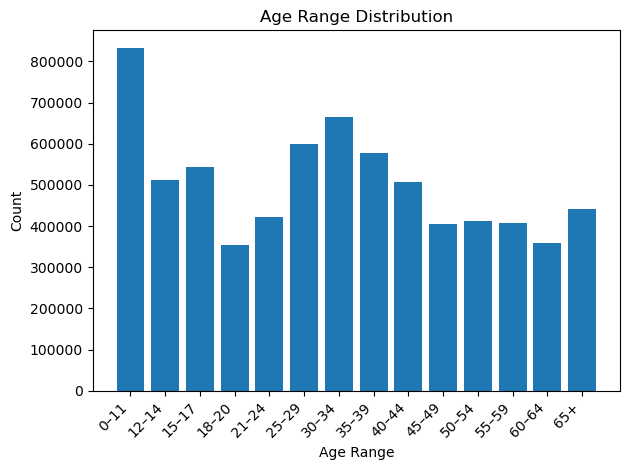

In [64]:
# Histogram of AGE
mapped = model_df["AGE"].map(age_map)

counts = mapped.value_counts().reindex(age_map.values())[:14]

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Age Range")
plt.ylabel("Count")
plt.title("Age Range Distribution")
plt.tight_layout()
plt.show()

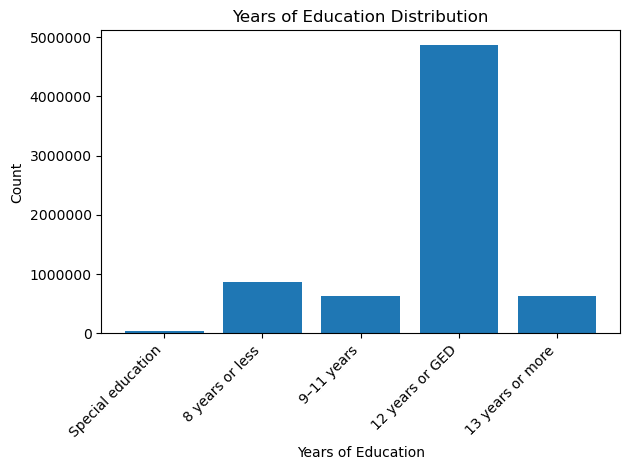

In [65]:
# Histogram of EDUC
mapped = model_df["EDUC"].map(educ_map)

counts = mapped.value_counts().reindex(educ_map.values())

plt.bar(counts.index, counts.values)
plt.ticklabel_format(style='plain', axis="y")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Years of Education")
plt.ylabel("Count")
plt.title("Years of Education Distribution")
plt.tight_layout()
plt.show()

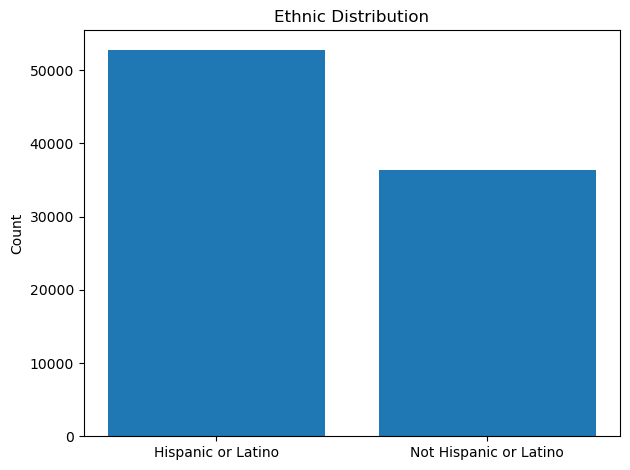

In [66]:
# Histogram of ETHNIC
mapped = model_df["ETHNIC"].map(ethnic_map)

counts = mapped.value_counts().reindex(ethnic_map.values())

plt.bar(counts.index, counts.values)
plt.ylabel("Count")
plt.title("Ethnic Distribution")
plt.tight_layout()
plt.show()


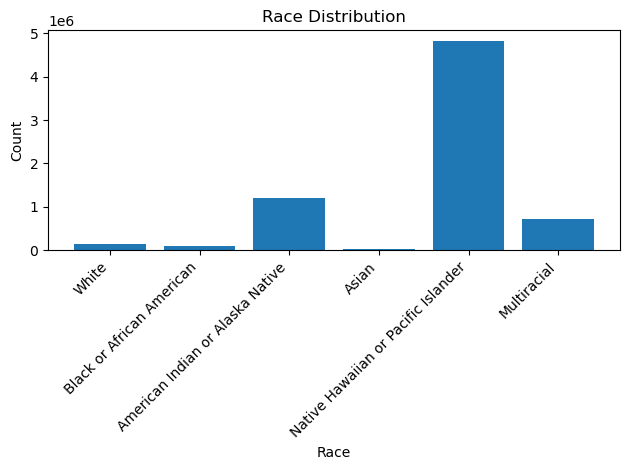

In [67]:
# Histogram of RACE
mapped = model_df["RACE"].map(race_map)

counts = mapped.value_counts().reindex(race_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Race")
plt.ylabel("Count")
plt.title("Race Distribution")
plt.tight_layout()
plt.show()

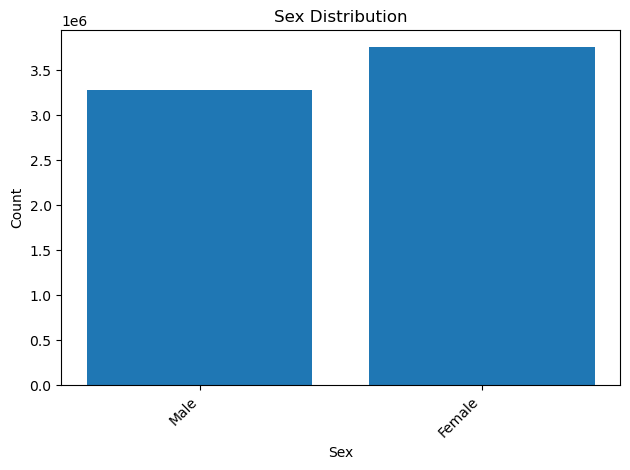

In [68]:
# Histogram of SEX
mapped = model_df["SEX"].map(sex_map)

counts = mapped.value_counts().reindex(sex_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.title("Sex Distribution")
plt.tight_layout()
plt.show()

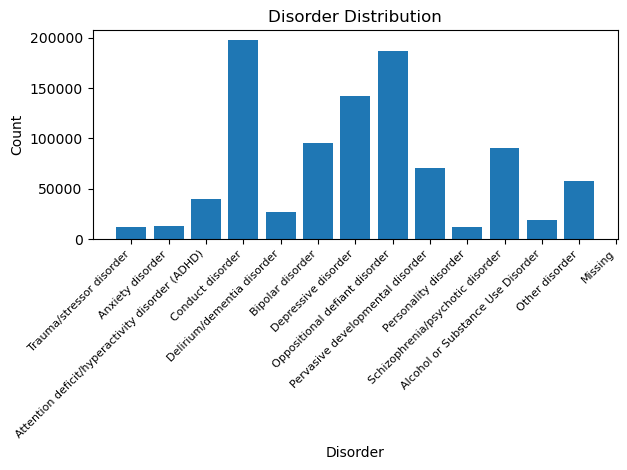

In [69]:
# Histogram of SUB

mapped = model_df["SUB"].map(sub_use_map)

counts = mapped.value_counts().reindex(sub_use_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right", fontsize=8)
plt.xlabel("Disorder")
plt.ylabel("Count")
plt.title("Disorder Distribution")
plt.tight_layout()
plt.show()

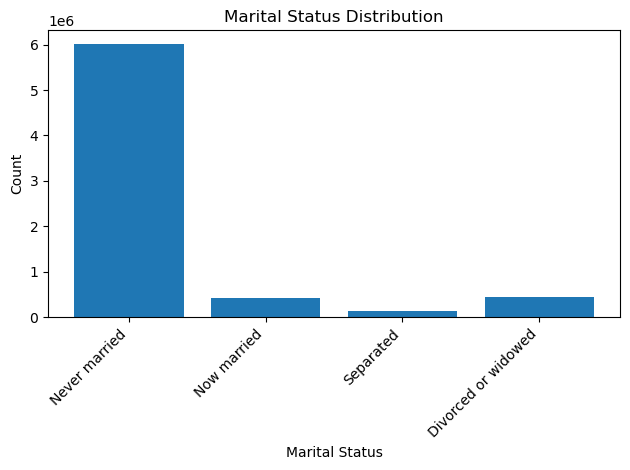

In [70]:
# Histogram of MARSTAT

mapped = model_df["MARSTAT"].map(marstat_map)

counts = mapped.value_counts().reindex(marstat_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Marital Status")
plt.ylabel("Count")
plt.title("Marital Status Distribution")
plt.tight_layout()
plt.show()

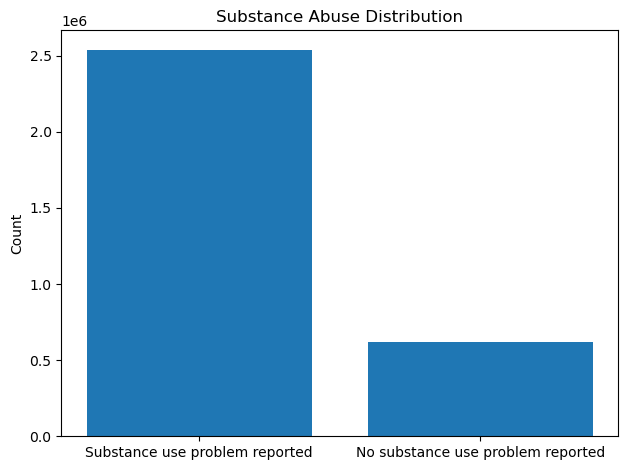

In [71]:
# Histogram of SAP
mapped = model_df["SAP"].map(sap_map)

counts = mapped.value_counts().reindex(sap_map.values())

plt.bar(counts.index, counts.values)
plt.xlabel("")
plt.ylabel("Count")
plt.title("Substance Abuse Distribution")
plt.tight_layout()
plt.show()


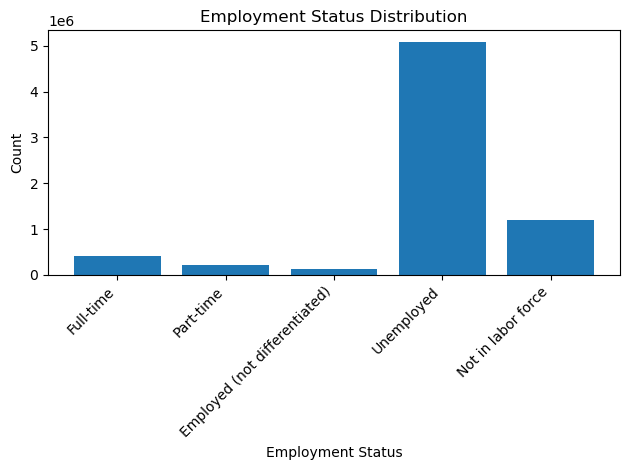

In [72]:
# Histogram of EMPLOY

mapped = model_df["EMPLOY"].map(employ_map)

counts = mapped.value_counts().reindex(employ_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Employment Status")
plt.ylabel("Count")
plt.title("Employment Status Distribution")
plt.tight_layout()
plt.show()


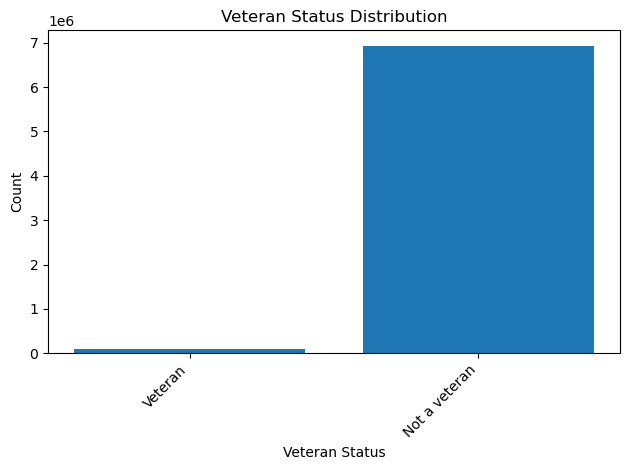

In [73]:
# Histogram of VETERAN

mapped = model_df["VETERAN"].map(veteran_map)

counts = mapped.value_counts().reindex(veteran_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Veteran Status")
plt.ylabel("Count")
plt.title("Veteran Status Distribution")
plt.tight_layout()
plt.show()


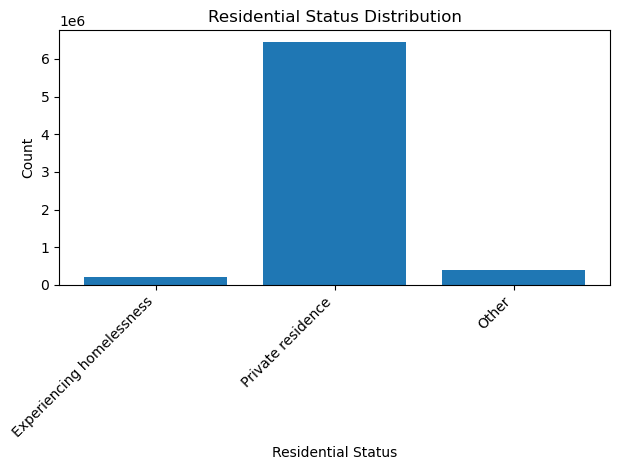

In [74]:
# Histogram of LIVARAG

mapped = model_df["LIVARAG"].map(livarag_map)

counts = mapped.value_counts().reindex(livarag_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Residential Status")
plt.ylabel("Count")
plt.title("Residential Status Distribution")
plt.tight_layout()
plt.show()

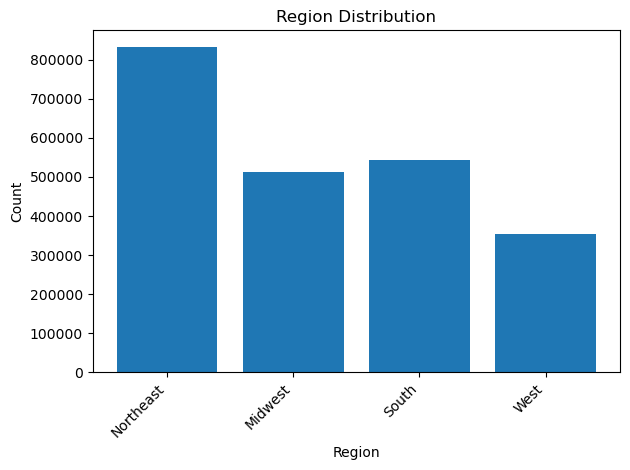

In [75]:
# Histogram of REGION

mapped = model_df["AGE"].map(region_map)

counts = mapped.value_counts().reindex(region_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Region")
plt.ylabel("Count")
plt.title("Region Distribution")
plt.tight_layout()
plt.show()


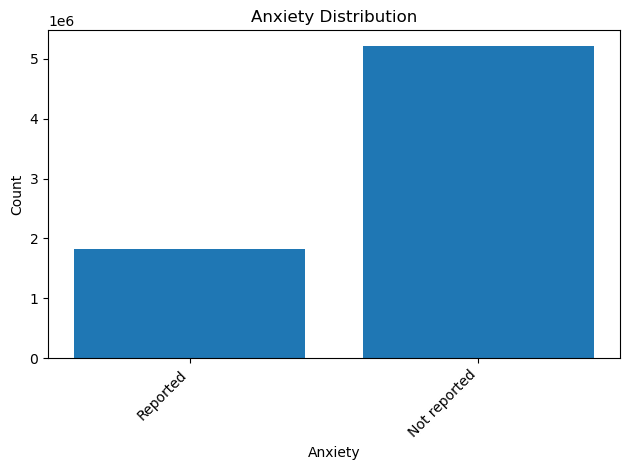

In [76]:
# Histogram of ANXIETYFLG

mapped = model_df["ANXIETYFLG"].map(binary_flag_map)

counts = mapped.value_counts().reindex(binary_flag_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Anxiety")
plt.ylabel("Count")
plt.title("Anxiety Distribution")
plt.tight_layout()
plt.show()


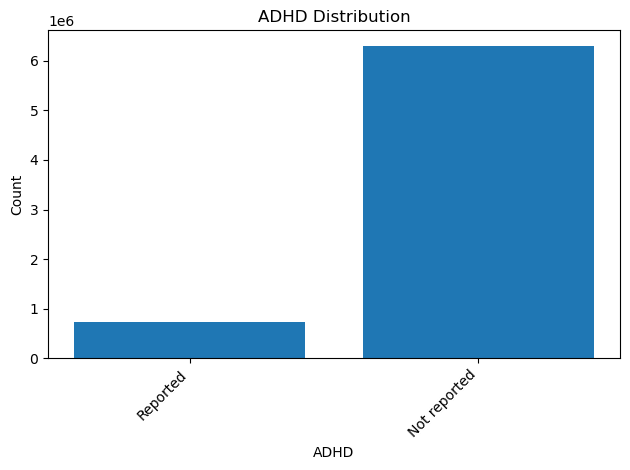

In [77]:
# Histogram of ADHDFLG

mapped = model_df["ADHDFLG"].map(binary_flag_map)

counts = mapped.value_counts().reindex(binary_flag_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("ADHD")
plt.ylabel("Count")
plt.title("ADHD Distribution")
plt.tight_layout()
plt.show()


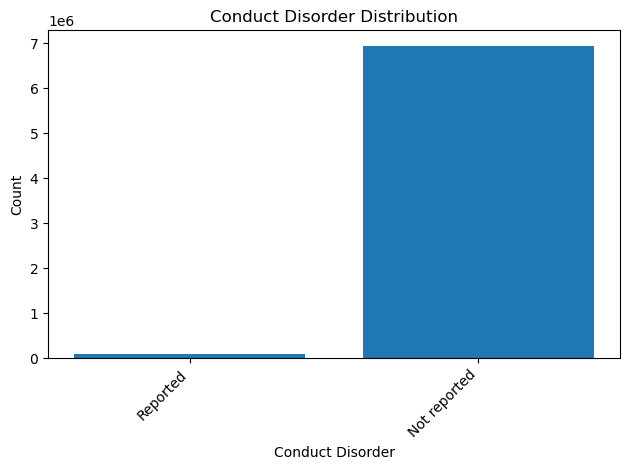

In [78]:
# Histogram of CONDUCTFLG

mapped = model_df["CONDUCTFLG"].map(binary_flag_map)

counts = mapped.value_counts().reindex(binary_flag_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Conduct Disorder")
plt.ylabel("Count")
plt.title("Conduct Disorder Distribution")
plt.tight_layout()
plt.show()


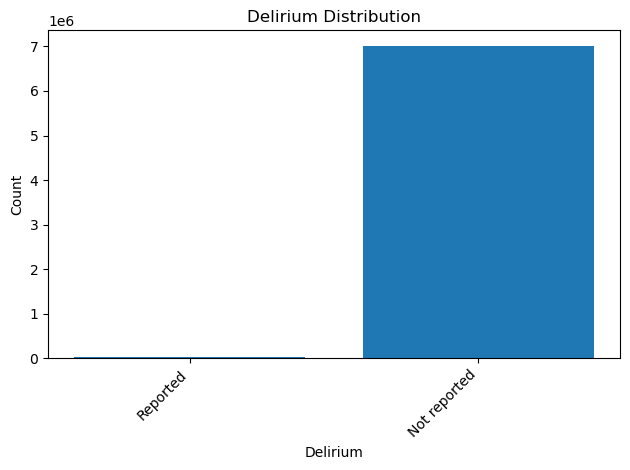

In [79]:
# Histogram of DELIRDEMFLG

mapped = model_df["DELIRDEMFLG"].map(binary_flag_map)

counts = mapped.value_counts().reindex(binary_flag_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Delirium")
plt.ylabel("Count")
plt.title("Delirium Distribution")
plt.tight_layout()
plt.show()


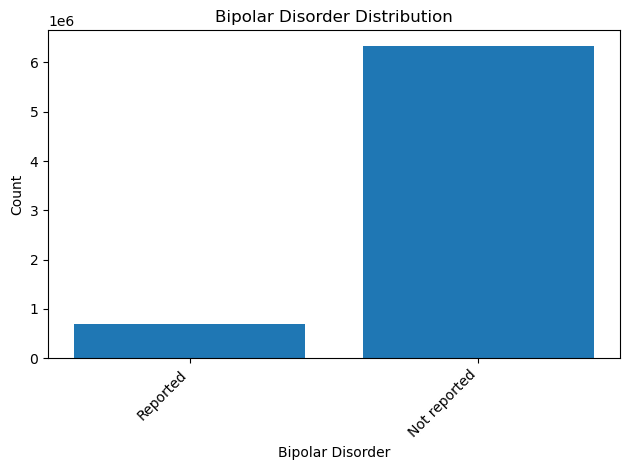

In [80]:
# Histogram of BIPOLARFLG

mapped = model_df["BIPOLARFLG"].map(binary_flag_map)

counts = mapped.value_counts().reindex(binary_flag_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Bipolar Disorder")
plt.ylabel("Count")
plt.title("Bipolar Disorder Distribution")
plt.tight_layout()
plt.show()


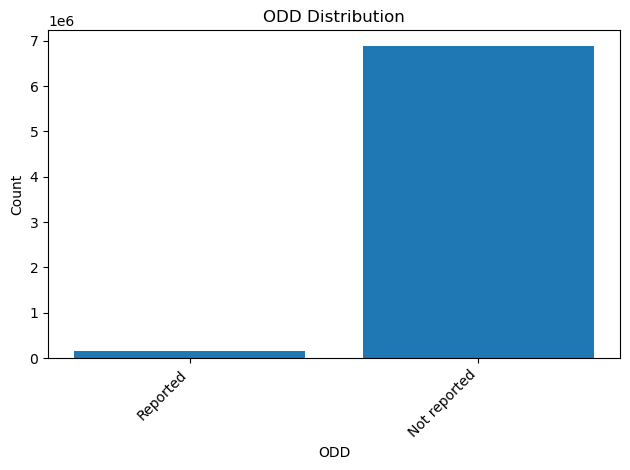

In [81]:
# Histogram of ODDFLG

mapped = model_df["ODDFLG"].map(binary_flag_map)

counts = mapped.value_counts().reindex(binary_flag_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("ODD")
plt.ylabel("Count")
plt.title("ODD Distribution")
plt.tight_layout()
plt.show()


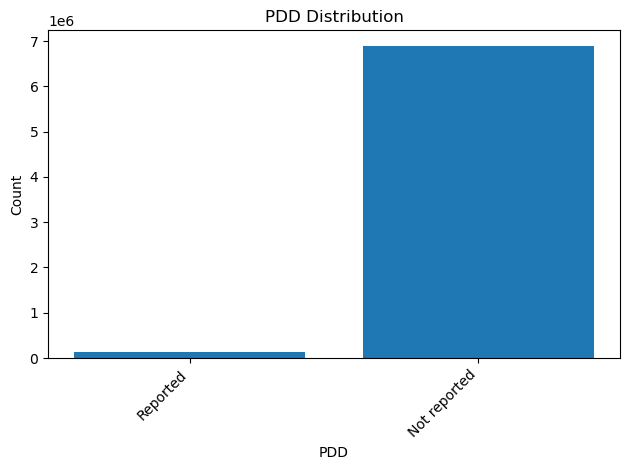

In [82]:
# Histogram of PDDFLG

mapped = model_df["PDDFLG"].map(binary_flag_map)

counts = mapped.value_counts().reindex(binary_flag_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("PDD")
plt.ylabel("Count")
plt.title("PDD Distribution")
plt.tight_layout()
plt.show()


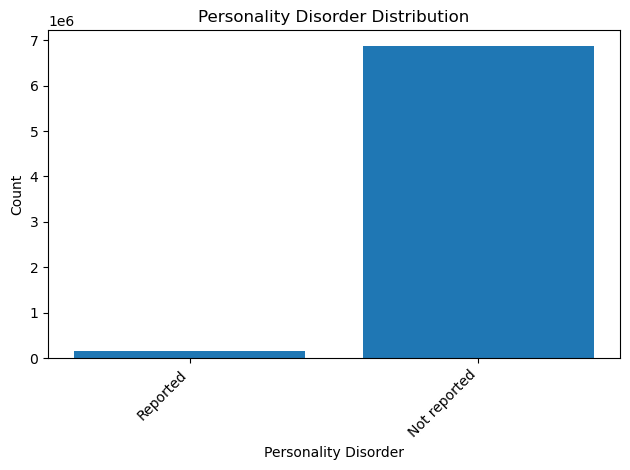

In [83]:
# Histogram of PERSONFLG

mapped = model_df["PERSONFLG"].map(binary_flag_map)

counts = mapped.value_counts().reindex(binary_flag_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Personality Disorder")
plt.ylabel("Count")
plt.title("Personality Disorder Distribution")
plt.tight_layout()
plt.show()


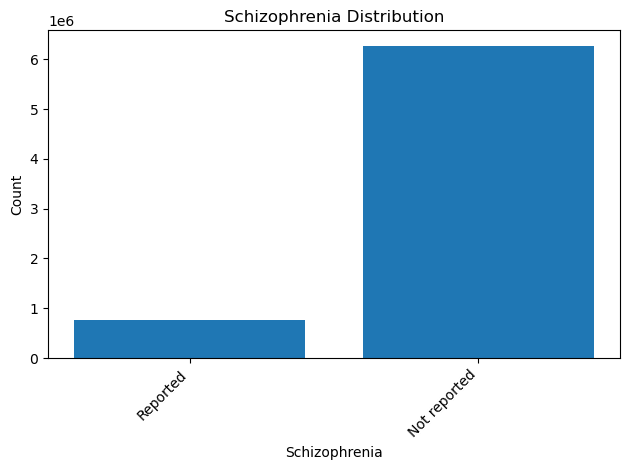

In [84]:
# Histogram of SCHIZOFLG

mapped = model_df["SCHIZOFLG"].map(binary_flag_map)

counts = mapped.value_counts().reindex(binary_flag_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Schizophrenia")
plt.ylabel("Count")
plt.title("Schizophrenia Distribution")
plt.tight_layout()
plt.show()


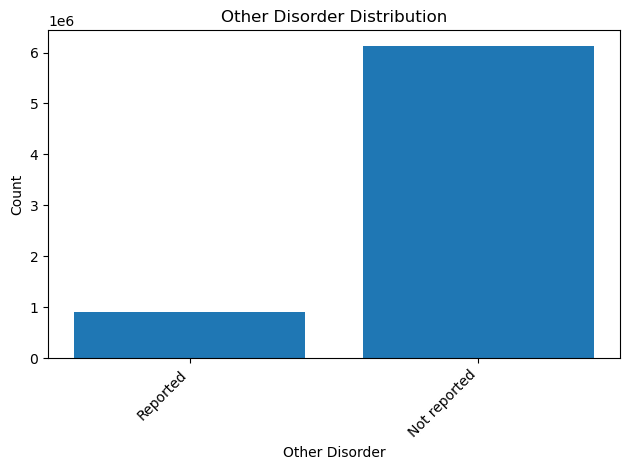

In [85]:
# Histogram of OTHERDISFLG

mapped = model_df["OTHERDISFLG"].map(binary_flag_map)

counts = mapped.value_counts().reindex(binary_flag_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Other Disorder")
plt.ylabel("Count")
plt.title("Other Disorder Distribution")
plt.tight_layout()
plt.show()


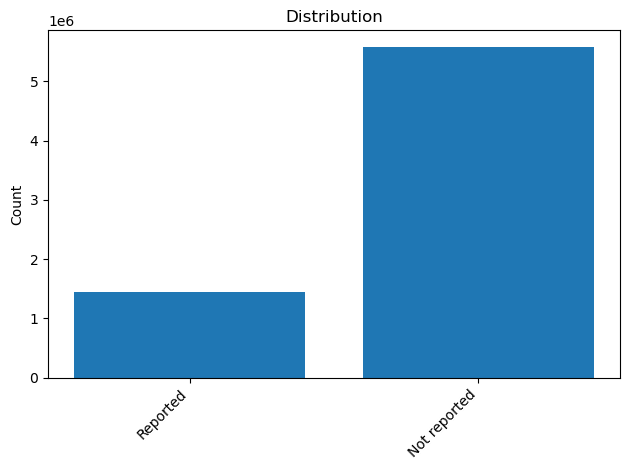

In [86]:
# Histogram of TRAUSTREFLG

mapped = model_df["TRAUSTREFLG"].map(binary_flag_map)

counts = mapped.value_counts().reindex(binary_flag_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("")
plt.ylabel("Count")
plt.title("Distribution")
plt.tight_layout()
plt.show()


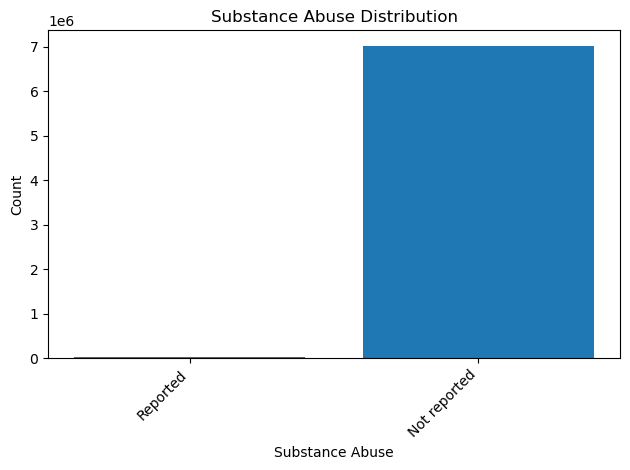

In [87]:
# Histogram of HAS_SUBSTANCE_USE

mapped = model_df["HAS_SUBSTANCE_USE"].map(binary_flag_map)

counts = mapped.value_counts().reindex(binary_flag_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Substance Abuse")
plt.ylabel("Count")
plt.title("Substance Abuse Distribution")
plt.tight_layout()
plt.show()


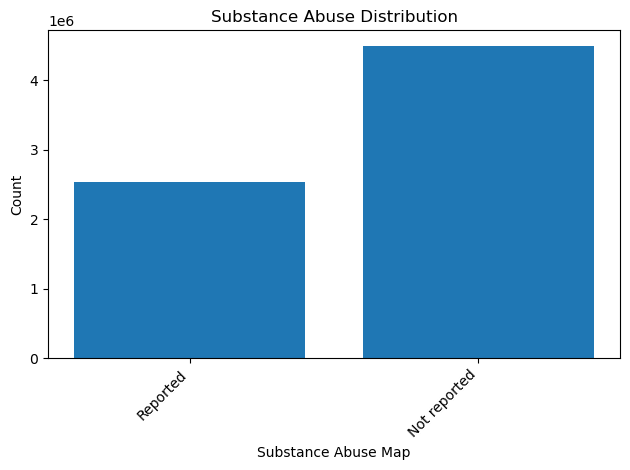

In [88]:
# Histogram of HAS_SAP

mapped = model_df["HAS_SAP"].map(binary_flag_map)

counts = mapped.value_counts().reindex(binary_flag_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Substance Abuse Map")
plt.ylabel("Count")
plt.title("Substance Abuse Distribution")
plt.tight_layout()
plt.show()


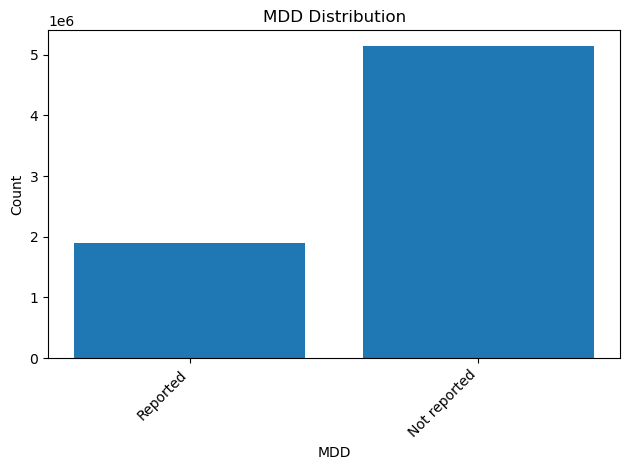

In [89]:
# Histogram of MDD

mapped = model_df["MDD"].map(binary_flag_map)

counts = mapped.value_counts().reindex(binary_flag_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("MDD")
plt.ylabel("Count")
plt.title("MDD Distribution")
plt.tight_layout()
plt.show()


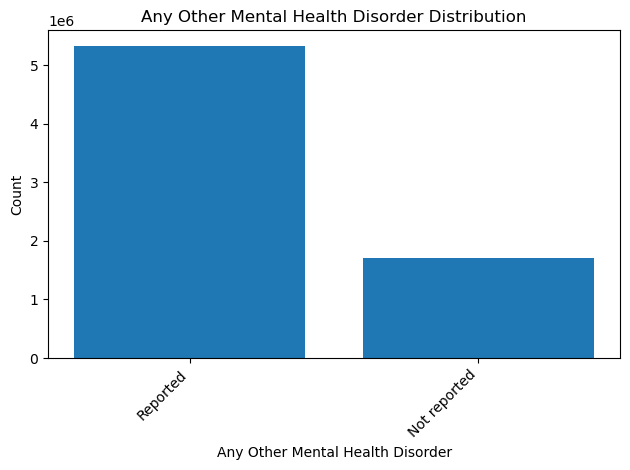

In [90]:
# Histogram of ANY_OTHER_MH_DISORDER

mapped = model_df["ANY_OTHER_MH_DISORDER"].map(binary_flag_map)

counts = mapped.value_counts().reindex(binary_flag_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Any Other Mental Health Disorder")
plt.ylabel("Count")
plt.title("Any Other Mental Health Disorder Distribution")
plt.tight_layout()
plt.show()


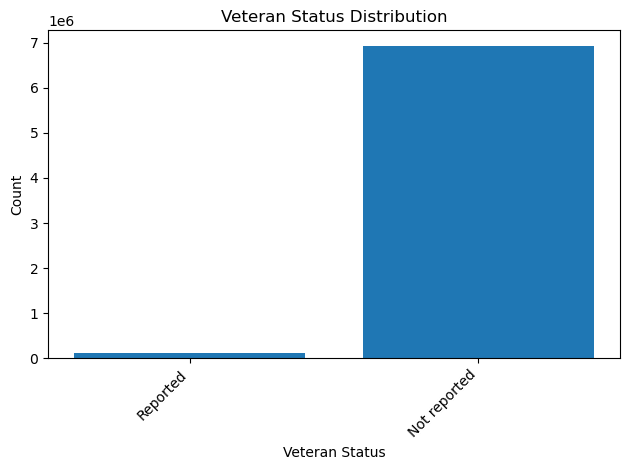

In [91]:
# Histogram of IS_VETERAN

mapped = model_df["IS_VETERAN"].map(binary_flag_map)

counts = mapped.value_counts().reindex(binary_flag_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Veteran Status")
plt.ylabel("Count")
plt.title("Veteran Status Distribution")
plt.tight_layout()
plt.show()


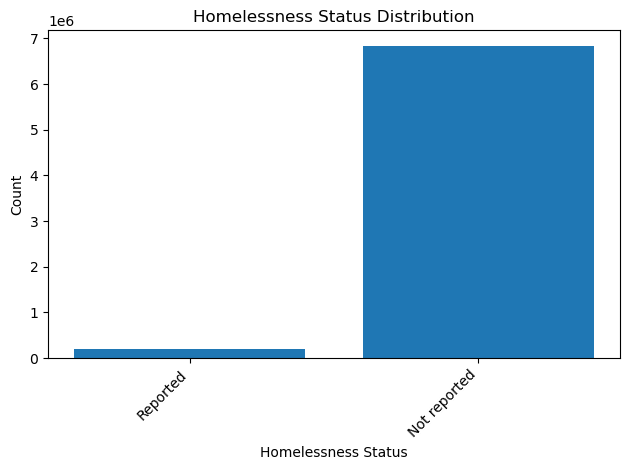

In [92]:
# Histogram of IS_HOMELESS

mapped = model_df["IS_HOMELESS"].map(binary_flag_map)

counts = mapped.value_counts().reindex(binary_flag_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Homelessness Status")
plt.ylabel("Count")
plt.title("Homelessness Status Distribution")
plt.tight_layout()
plt.show()


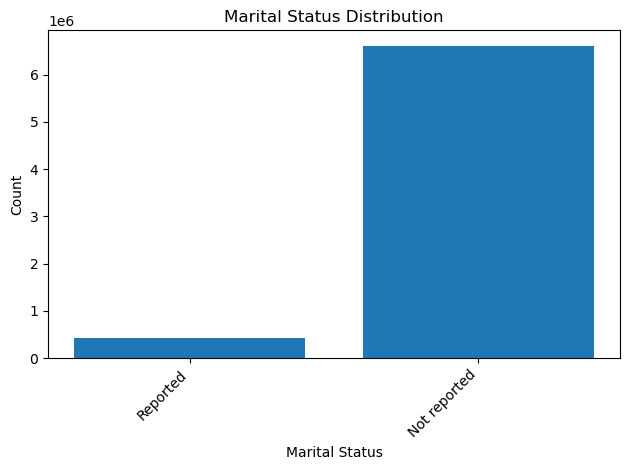

In [93]:
# Histogram of IS_MARRIED

mapped = model_df["IS_MARRIED"].map(binary_flag_map)

counts = mapped.value_counts().reindex(binary_flag_map.values())

plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Marital Status")
plt.ylabel("Count")
plt.title("Marital Status Distribution")
plt.tight_layout()
plt.show()


In [94]:
# Abby's section

## Multicollinearity Check With VIF

In [96]:
cols_for_model = [c for c in X_train_full.columns if c != "VETERAN"] ## drop original VETERAN because perfectly collinear with IS_VETERAN
X_vif = sm.add_constant(X_train_full[cols_for_model]) ## add constant to design matrix for VIF computation

## data frame to store VIF values
vif_df = pd.DataFrame({
    "Variable": X_vif.columns, ## store variable names
    "VIF": [ ## compute vif for each column
    variance_inflation_factor(X_vif.values, i)
    for i in range(X_vif.shape[1])
]
})
vif_df.sort_values("VIF",ascending=False) ## display vif vals (largest -> smallest)

,Variable,VIF
0,const,261.002658
26,ANY_OTHER_MH_DISORDER,2.432109
25,HAS_SAP,1.815293
28,IS_HOMELESS,1.673291
10,LIVARAG,1.653880
6,SUB,1.590906
12,ANXIETYFLG,1.583975
1,AGE,1.552491
11,TRAUSTREFLG,1.517850
8,SAP,1.514066


## Logistic Regression

In [98]:
## Add intercept to training data
X_train_sm = sm.add_constant(X_train_full[cols_for_model])
## Add intercept to test data
X_test_sm = sm.add_constant(X_test[cols_for_model],has_constant="add")

## define logistic regression model
logit_model = sm.Logit(y_train_full, X_train_sm)
## fit logistic model
logit_res = logit_model.fit()

## summary of logistic regression results
print(logit_res.summary())

Optimization terminated successfully.
         Current function value: 0.484651
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    MDD   No. Observations:              5628512
Model:                          Logit   Df Residuals:                  5628482
Method:                           MLE   Df Model:                           29
Date:                Mon, 08 Dec 2025   Pseudo R-squ.:                  0.1675
Time:                        19:44:21   Log-Likelihood:            -2.7279e+06
converged:                       True   LL-Null:                   -3.2768e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -1.2830      0.018    -72.774      0.000      -1.318      -1.

## Odds Ratios

In [100]:
## extract estimated coefficients from fitted logit model
params = logit_res.params
## extract confidence intervals
conf = logit_res.conf_int()
## name confidence interval columns
conf.columns = ["2.5%", "97.5%"]

## table of odds ratios and confidence intervals
or_table = pd.DataFrame({
    "Odds_Ratio": np.exp(params), ## log-odds coefficients to odds ratios
    "CI_2.5%": np.exp(conf["2.5%"]), ## lower bound of 95% CI
    "CI_97.5%": np.exp(conf["97.5%"]), ## upper bound of 95% CI
    "p_value": logit_res.pvalues ## corresponding p vals for hypothesis tests
})
## view, sorted by p values
or_table.sort_values("p_value")

,Odds_Ratio,CI_2.5%,CI_97.5%,p_value
const,0.277206,0.267791,0.286952,0.000000e+00
ANY_OTHER_MH_DISORDER,0.272800,0.270694,0.274923,0.000000e+00
HAS_SAP,1.454167,1.445454,1.462932,0.000000e+00
OTHERDISFLG,0.603206,0.598365,0.608086,0.000000e+00
ALCSUBFLG,0.757273,0.748740,0.765903,0.000000e+00
SCHIZOFLG,0.190262,0.188070,0.192480,0.000000e+00
PERSONFLG,1.483828,1.463708,1.504225,0.000000e+00
PDDFLG,0.551002,0.539247,0.563013,0.000000e+00
ODDFLG,0.623860,0.610878,0.637118,0.000000e+00
BIPOLARFLG,0.174988,0.173067,0.176931,0.000000e+00


## Odds Ratio Plot (top predictors)

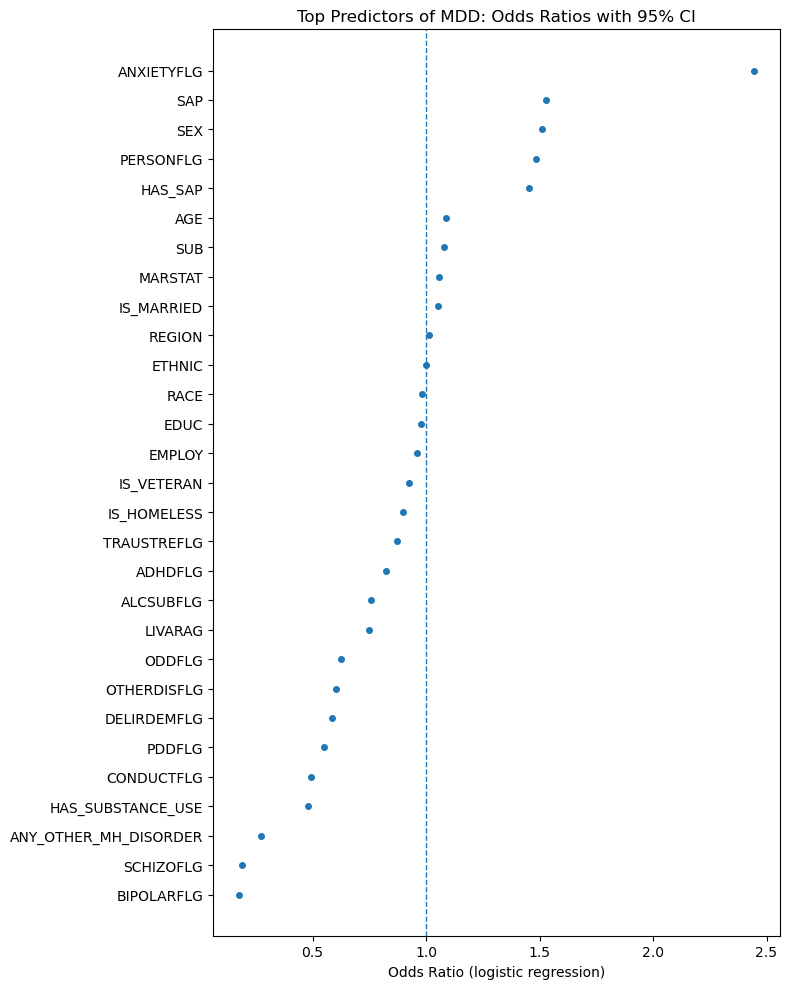

In [102]:
or_plot = or_table.drop(index="const") ## drop intercept for plotting

or_plot = or_plot.sort_values("Odds_Ratio") ## sort by odds ratio

## positions for predictors on y axis
y_pos = np.arange(len(or_plot))

## horizontal odds ratio plot 95% CI
plt.figure(figsize=(8,10))

## values for plotting
odds = or_plot["Odds_Ratio"].values

## odds ratios as points
plt.plot(
    odds,
    y_pos,
    "o",
    markersize = 4
)
plt.axvline(1.0,linestyle="--",linewidth=1) ## reference line OR=1 (no effect)

plt.yticks(y_pos, or_plot.index) ## label y axis with predictor names
plt.xlabel("Odds Ratio (logistic regression)")
plt.title("Top Predictors of MDD: Odds Ratios with 95% CI")
plt.tight_layout()
plt.show()

## Probit Regression

In [104]:
## define probit regression model
probit_model = sm.Probit(y_train_full, X_train_sm)
## fit probit model
probit_res = probit_model.fit()

## summary of probit regression
print(probit_res.summary())

Optimization terminated successfully.
         Current function value: 0.485424
         Iterations 6
                          Probit Regression Results                           
Dep. Variable:                    MDD   No. Observations:              5628512
Model:                         Probit   Df Residuals:                  5628482
Method:                           MLE   Df Model:                           29
Date:                Mon, 08 Dec 2025   Pseudo R-squ.:                  0.1662
Time:                        19:44:35   Log-Likelihood:            -2.7322e+06
converged:                       True   LL-Null:                   -3.2768e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.7646      0.010    -75.443      0.000      -0.784      -0.

## Logistic vs Probit Coefficient Comparison

In [106]:
## data frame to compare coefficients and p-values
comparison = pd.DataFrame({
    "Logit_coefficients": logit_res.params, ## estimated coefficients from logistic regression
    "Logit_p": logit_res.pvalues, ## corresponding p-values
    "Probit_coefficients": probit_res.params, ## estimated coefficients from probit regression
    "Probit_p": probit_res.pvalues ## corresponding p-values
})
comparison ## display comparison table

,Logit_coefficients,Logit_p,Probit_coefficients,Probit_p
const,-1.282995,0.000000e+00,-0.764572,0.000000e+00
AGE,0.083901,0.000000e+00,0.050505,0.000000e+00
EDUC,-0.021990,2.853646e-50,-0.012403,4.681598e-48
ETHNIC,0.000406,8.610711e-01,0.001438,2.880626e-01
RACE,-0.017073,5.090856e-62,-0.009141,1.642610e-52
SEX,0.412467,0.000000e+00,0.241147,0.000000e+00
SUB,0.074140,0.000000e+00,0.043337,0.000000e+00
MARSTAT,0.056040,0.000000e+00,0.029430,1.814311e-279
SAP,0.422982,0.000000e+00,0.233114,0.000000e+00
EMPLOY,-0.041251,5.510659e-297,-0.025920,0.000000e+00


## Model Fit Metrics

In [108]:
## predicted probabilities 
logit_probs = logit_res.predict(X_test_sm) 
probit_probs = probit_res.predict(X_test_sm)

## Area under ROC curve (AUC)
logit_auc = roc_auc_score(y_test, logit_probs)
probit_auc = roc_auc_score(y_test, probit_probs)

print("Logistic AUC:", logit_auc)
print("Probit AUC:", probit_auc)

## Akaike (AIC) / Bayesian (BIC) information criteria
print("Logistic AIC:", logit_res.aic)
print("Logistic BIC:", logit_res.bic)
print("Probit AIC:", probit_res.aic)
print("Probit BIC:", probit_res.bic)

Logistic AUC: 0.776456541748369
Probit AUC: 0.7761911955685163
Logistic AIC: 5455786.568210126
Logistic BIC: 5456192.868880129
Probit AIC: 5464492.838982841
Probit BIC: 5464899.1396528445


## ROC Curve: Logistic vs Probit

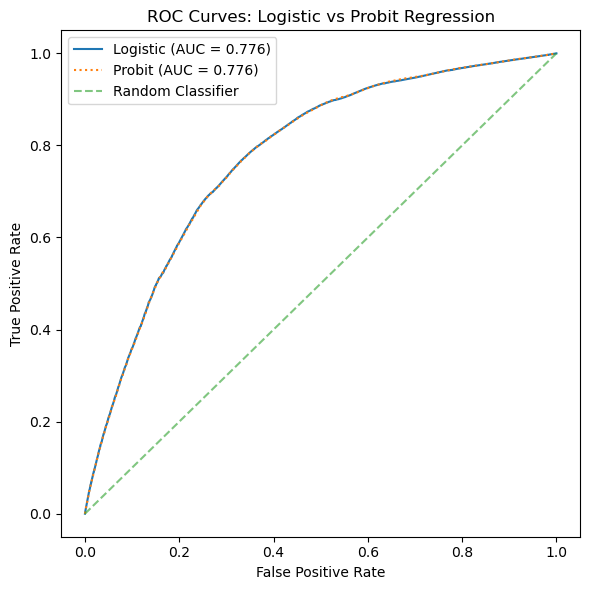

In [110]:
## false positive and true positive values
fpr_logit, tpr_logit, _ = roc_curve(y_test, logit_probs)
fpr_probit, tpr_probit, _ = roc_curve(y_test, probit_probs)

plt.figure(figsize=(6,6))

## plot ROC curves
plt.plot(
    fpr_logit,
    tpr_logit,
    label = f"Logistic (AUC = {logit_auc:.3f})"
)
plt.plot(
    fpr_probit,
    tpr_probit,
    linestyle=":",
    label = f"Probit (AUC = {probit_auc:.3f})"
)

plt.plot([0,1], [0,1], linestyle="--", alpha = 0.6, label="Random Classifier") ## reference line

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves: Logistic vs Probit Regression")
plt.legend()
plt.tight_layout()
plt.show()

## Predictive Modeling

### Random Forest Model

In [113]:
# Defining random forest model
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    max_features="sqrt",
    n_jobs=-1,
    class_weight="balanced",
    random_state=42
)


In [114]:
# Fitting random forest model
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=15, n_estimators=200,
                       n_jobs=-1, random_state=42)

In [115]:
# Making predictions on test data
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

### Stochastic Gradient Descent (SGD) Model

Since we are unable to use a support vector machine model with data of this size, we implement a stochastic gradient descent model instead.

In [118]:
# Scaling the data and fitting the model
sgd = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("sgd", SGDClassifier(
        loss="log_loss",
        max_iter=1000,
        tol=1e-3,
        random_state=42
    ))
])

In [119]:
# Fitting the model
sgd.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler(with_mean=False)),
                ('sgd', SGDClassifier(loss='log_loss', random_state=42))])

In [120]:
# Making predictions on test data
y_pred = sgd.predict(X_test)

### Light Gradient Boosting Machine (LIGHTGBM) Model

In [122]:
# Defining LIGHTBGM model
lgbm = lgb.LGBMClassifier(
    num_leaves=64,
    learning_rate=0.05,
    n_estimators=500,
    min_child_samples=50,
    subsample=0.8,
    colsample_bytree=0.8
)

In [123]:
# Fitting LIGHTBGM model
lgbm.fit(X_train, y_train,eval_set=[(X_val, y_val)],eval_metric="auc")

[LightGBM] [Info] Number of positive: 1210878, number of negative: 3291931
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.093506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 112
[LightGBM] [Info] Number of data points in the train set: 4502809, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.268916 -> initscore=-1.000129
[LightGBM] [Info] Start training from score -1.000129


LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, min_child_samples=50,
               n_estimators=500, num_leaves=64, subsample=0.8)

In [124]:
# Making predictions on test data
y_pred = lgbm.predict(X_test)
y_prob = lgbm.predict_proba(X_test)[:,1]

### CatBoost Model

In [126]:
# Defining CatBoost model
cat = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.03,
    depth=6,
    od_type="Iter",
    od_wait=40,
    task_type="CPU",
    verbose=100
)


In [127]:
# Fitting CatBoost model
cat.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    use_best_model=True
)


0:	learn: 0.6770582	test: 0.6770942	best: 0.6770942 (0)	total: 165ms	remaining: 5m 30s
100:	learn: 0.4567239	test: 0.4569899	best: 0.4569899 (100)	total: 9.17s	remaining: 2m 52s
200:	learn: 0.4418068	test: 0.4422059	best: 0.4422059 (200)	total: 18s	remaining: 2m 41s
300:	learn: 0.4357896	test: 0.4362120	best: 0.4362120 (300)	total: 26.9s	remaining: 2m 31s
400:	learn: 0.4324449	test: 0.4328728	best: 0.4328728 (400)	total: 35.7s	remaining: 2m 22s
500:	learn: 0.4296269	test: 0.4300561	best: 0.4300561 (500)	total: 44.5s	remaining: 2m 13s
600:	learn: 0.4275603	test: 0.4280030	best: 0.4280030 (600)	total: 53.3s	remaining: 2m 4s
700:	learn: 0.4256774	test: 0.4261234	best: 0.4261234 (700)	total: 1m 2s	remaining: 1m 55s
800:	learn: 0.4241737	test: 0.4246237	best: 0.4246237 (800)	total: 1m 11s	remaining: 1m 46s
900:	learn: 0.4228712	test: 0.4233285	best: 0.4233285 (900)	total: 1m 20s	remaining: 1m 38s
1000:	learn: 0.4214011	test: 0.4218686	best: 0.4218686 (1000)	total: 1m 29s	remaining: 1m 29s
1

In [128]:
# Making predictions on test data
y_pred = cat.predict(X_test)
y_prob = cat.predict_proba(X_test)[:, 1]

### Saving Models

In [130]:
# Saving models
joblib.dump(rf, "random_forest_model.pkl")
joblib.dump(sgd, "sgd_model.pkl")
joblib.dump(lgbm, "lightgbm_model.pkl")

['lightgbm_model.pkl']

In [131]:
# Loading models
rf = joblib.load("random_forest_model.pkl")
sgd = joblib.load("sgd_model.pkl")
lgbm = joblib.load("lightgbm_model.pkl")

In [132]:
# Saving CatBoost model
cat.save_model("catboost_model.cbm")

In [133]:
# Loading CatBoost model
cat = CatBoostClassifier()
cat.load_model("catboost_model.cbm")

## Model Evaluation

### Creating a 'Model Evaluation Function'

In [155]:
def evaluate_model(model, X_test, y_test, model_name="Model"):
    print(f"\n{model_name}")

    # Making predictions on the testing set
    y_pred = model.predict(X_test)

    # Obtaining probabilities (if possible)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_test)
        # Converting scores to 0–1 using min-max scaling
        y_prob = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min())
    else:
        y_prob = None

    # Displaying evaluation metrics
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))

    if y_prob is not None:
        print("AUC:", roc_auc_score(y_test, y_prob))
        print("Brier Score:", brier_score_loss(y_test, y_prob))

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Displaying Confusion Matrix
    con_mat = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        con_mat,
        annot=True,
        fmt="d",
        cmap="Blues",
        linewidths=.5,
        linecolor='black'
    )
    plt.title(f"{model_name} - Confusion Matrix", fontsize=14)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

    # Displaying ROC Curve
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc = roc_auc_score(y_test, y_prob)
        plt.figure(figsize=(7,6))
        plt.plot(fpr, tpr, color="#5b3eb5", linewidth=2.5, label=f"AUC = {auc:.3f}")
        plt.plot([0, 1], [0, 1], linestyle="--", color="gray", linewidth=1.5)
        plt.title(f"{model_name} - ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(frameon=True)
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    # Displaying Calibration Curve
    if y_prob is not None:
        prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
        plt.figure(figsize=(7,6))
        plt.plot(prob_pred, prob_true, marker="o", linestyle="-", color="#5887b0", linewidth=2)
        plt.plot([0, 1], [0, 1], "--", color="gray", linewidth=1.5)
        plt.title(f"{model_name} - Calibration Curve")
        plt.xlabel("Predicted Probability")
        plt.ylabel("Actual Probability")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    # Displaying Probability Curve
    if y_prob is not None:
        plt.figure(figsize=(7,6))
        sns.histplot(y_prob, bins=30, kde=True, color="#819bd4")

        plt.title(f"{model_name} - Predicted Probability Distribution", fontsize=15)
        plt.xlabel("Predicted Probability")
        plt.ylabel("Count")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    return y_pred, y_prob


### Evaluating Each Model


Random Forest
Accuracy: 0.7346632753642346
Precision: 0.5041417452066104
Recall: 0.8101400634249472
F1 Score: 0.6215187987150232
AUC: 0.8356286236344495
Brier Score: 0.16995377766515785

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.71      0.80   1028729
         1.0       0.50      0.81      0.62    378400

    accuracy                           0.73   1407129
   macro avg       0.71      0.76      0.71   1407129
weighted avg       0.80      0.73      0.75   1407129



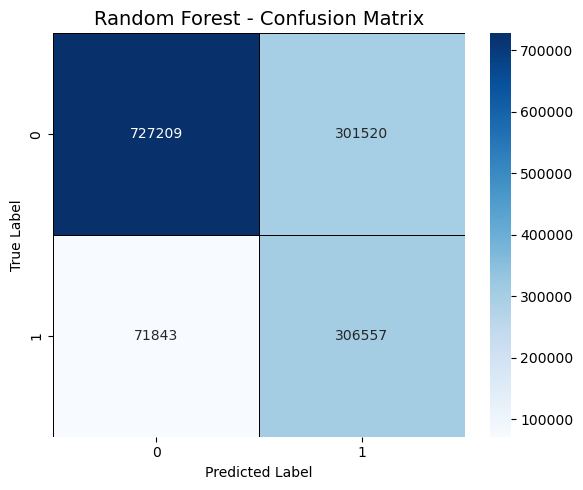

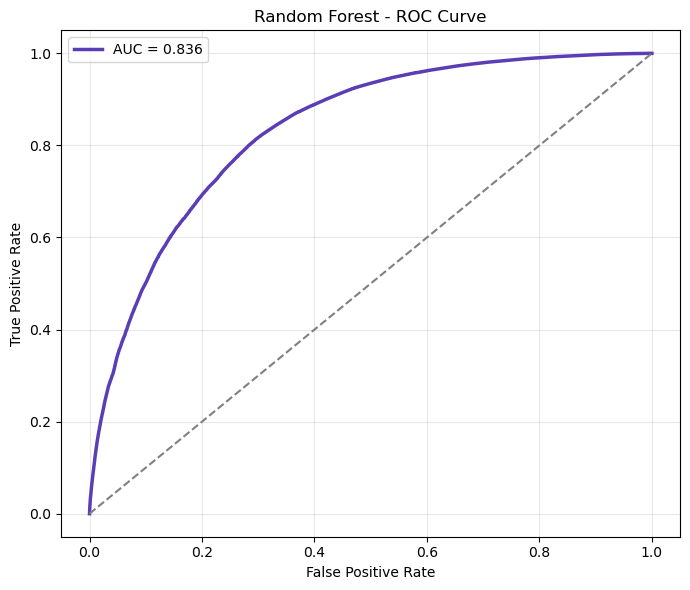

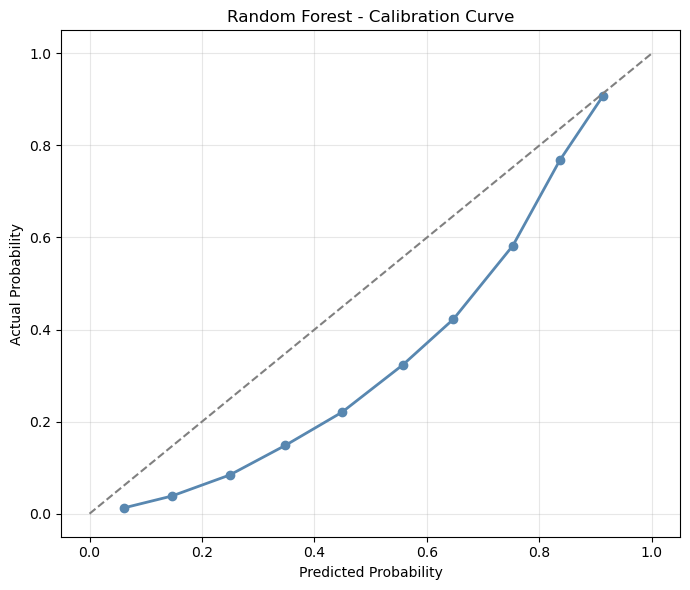

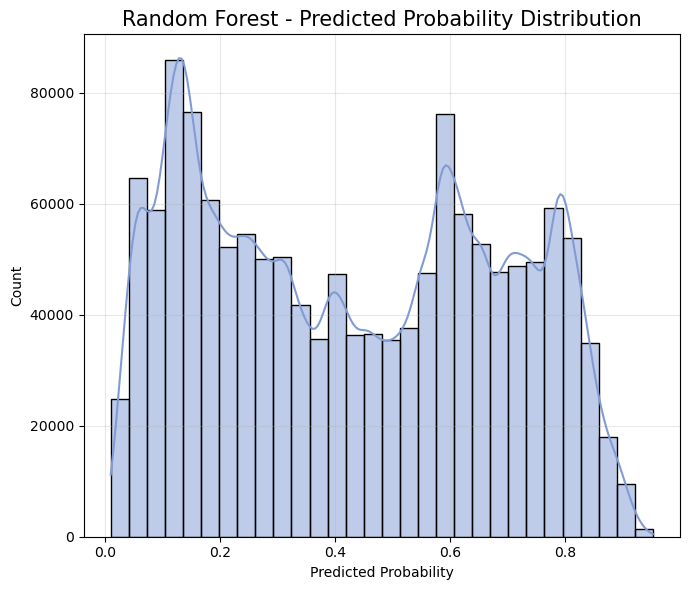

(array([1., 1., 0., ..., 0., 1., 1.]),
 array([0.85223954, 0.8082115 , 0.12056849, ..., 0.13848726, 0.79881063,
        0.58314219]))

In [138]:
evaluate_model(rf, X_test, y_test, model_name="Random Forest")


SGD Classifier
Accuracy: 0.7546124058277528
Precision: 0.5718271358528225
Recall: 0.34827959830866806
F1 Score: 0.43289700592901603
AUC: 0.7763335762605493
Brier Score: 0.1597731742844091

Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.90      0.84   1028729
         1.0       0.57      0.35      0.43    378400

    accuracy                           0.75   1407129
   macro avg       0.68      0.63      0.64   1407129
weighted avg       0.73      0.75      0.73   1407129



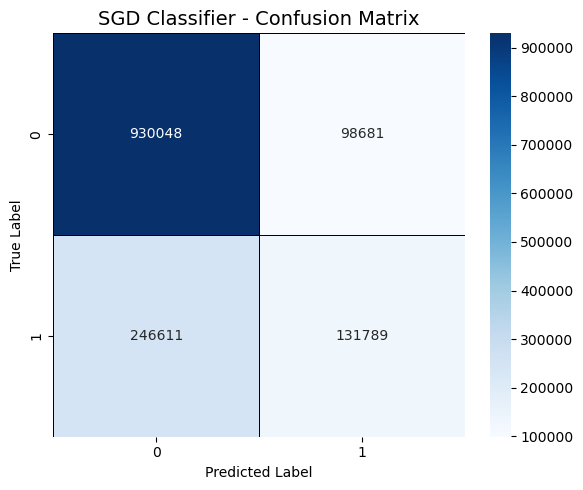

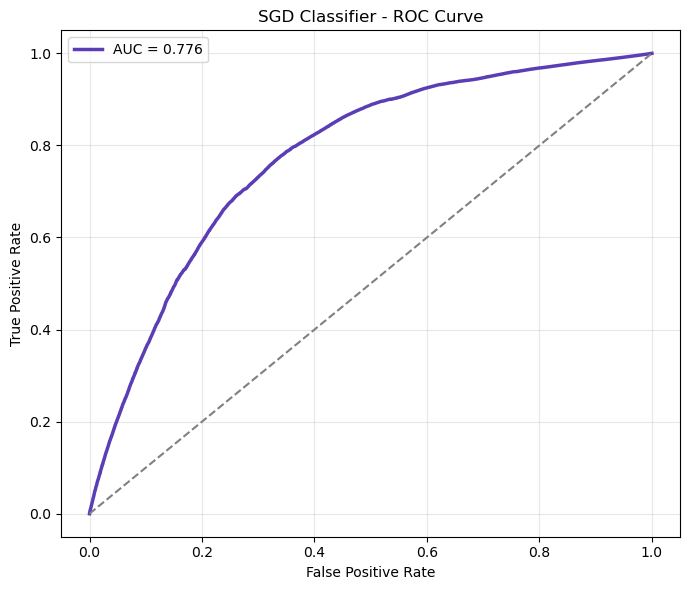

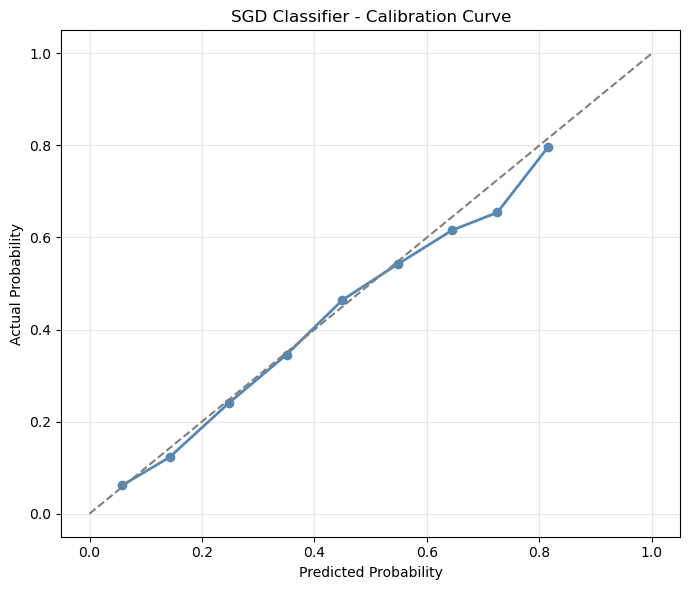

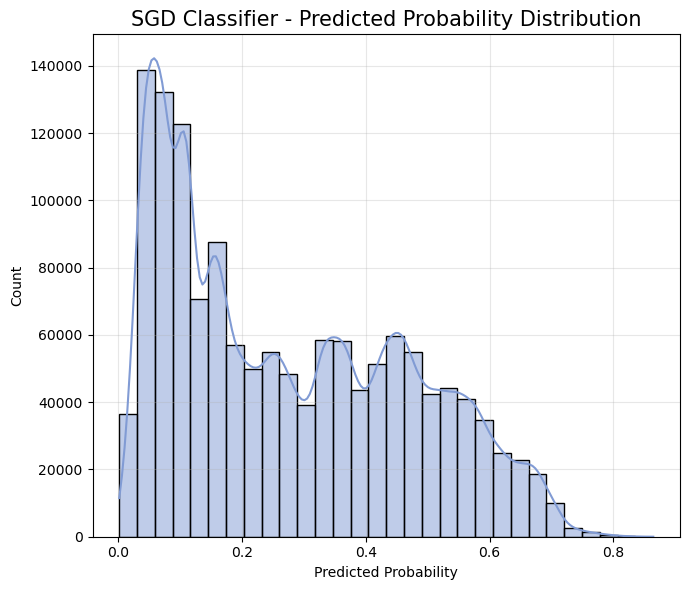

(array([1., 1., 0., ..., 0., 1., 0.]),
 array([0.52808517, 0.77052616, 0.04746395, ..., 0.04228146, 0.58489992,
        0.25379404]))

In [139]:
evaluate_model(sgd, X_test, y_test, model_name="SGD Classifier")


LightGBM
Accuracy: 0.8030834415323684
Precision: 0.6815469470696385
Recall: 0.5025634249471459
F1 Score: 0.5785281103453311
AUC: 0.8497032854923791
Brier Score: 0.13413228185032244

Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.91      0.87   1028729
         1.0       0.68      0.50      0.58    378400

    accuracy                           0.80   1407129
   macro avg       0.76      0.71      0.73   1407129
weighted avg       0.79      0.80      0.79   1407129



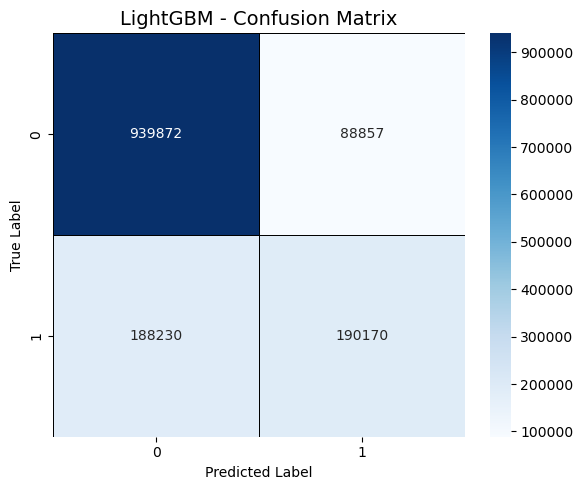

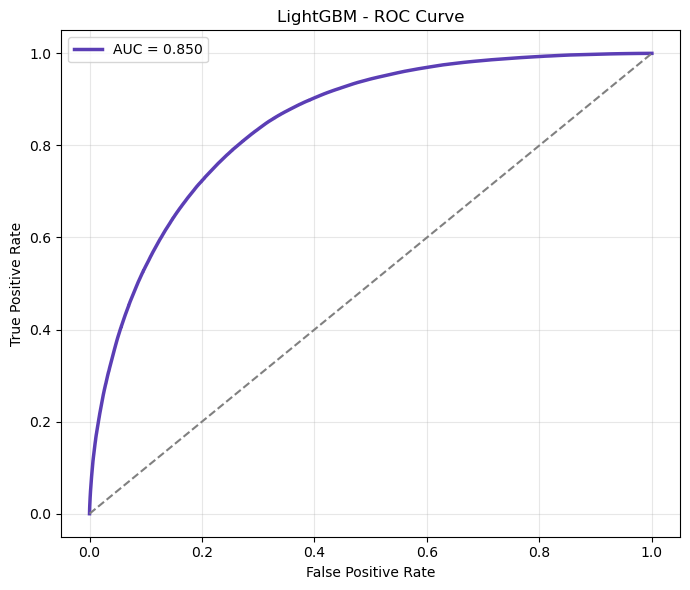

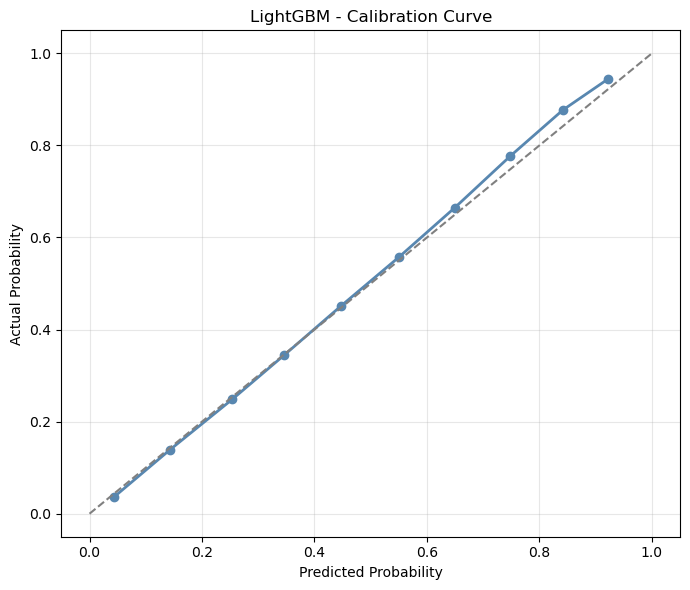

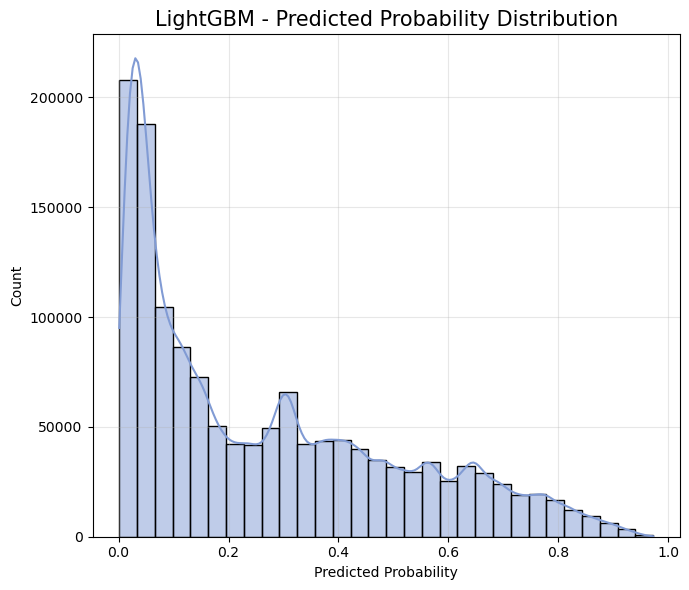

(array([1., 1., 0., ..., 0., 1., 0.]),
 array([0.7821158 , 0.71610112, 0.03370658, ..., 0.03907488, 0.550507  ,
        0.34158893]))

In [140]:
evaluate_model(lgbm, X_test, y_test, model_name="LightGBM")


CatBoost
Accuracy: 0.8012349969334723
Precision: 0.6762865388461868
Recall: 0.5003805496828753
F1 Score: 0.5751850006683111
AUC: 0.8472314269940361
Brier Score: 0.13529424843143037

Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.91      0.87   1028729
         1.0       0.68      0.50      0.58    378400

    accuracy                           0.80   1407129
   macro avg       0.75      0.71      0.72   1407129
weighted avg       0.79      0.80      0.79   1407129



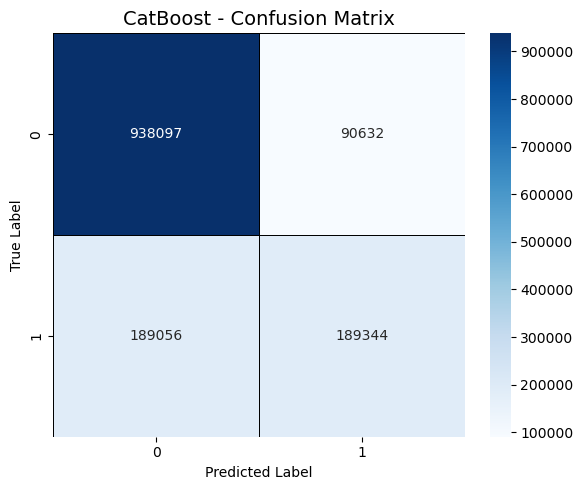

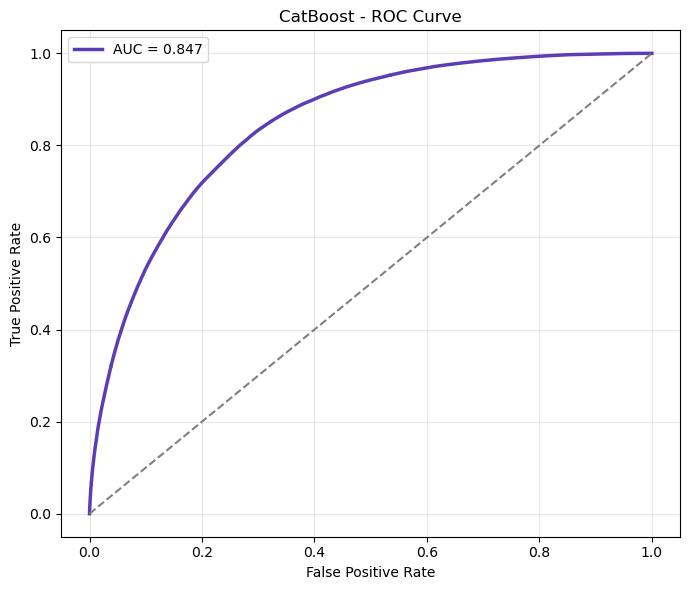

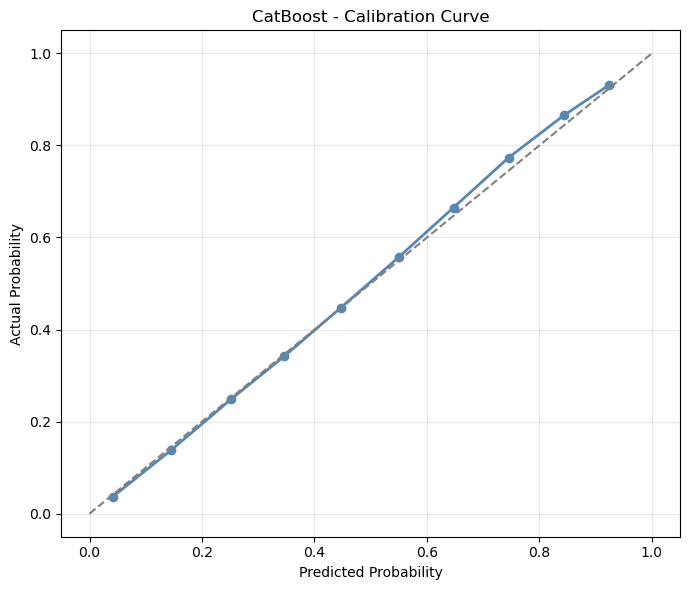

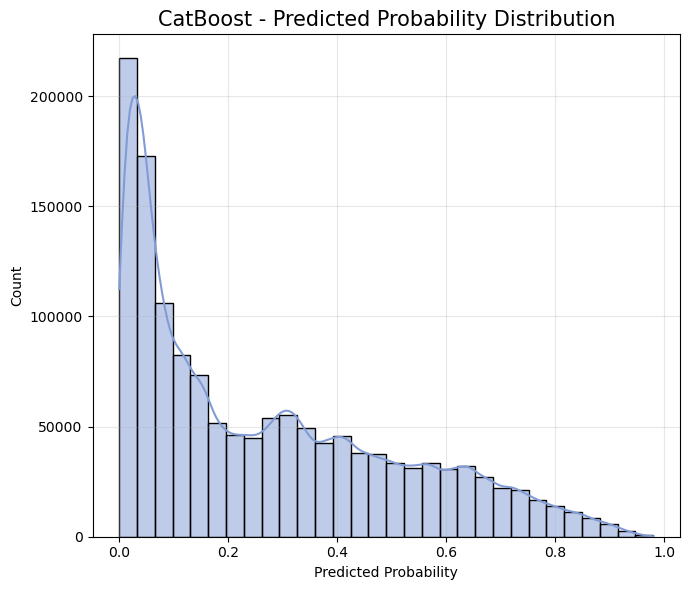

(array([1., 1., 0., ..., 0., 1., 0.]),
 array([0.79389806, 0.75359352, 0.03973443, ..., 0.03387533, 0.53673163,
        0.35181125]))

In [141]:
evaluate_model(cat, X_test, y_test, model_name="CatBoost")

### Feature Importance for Tree-Based Models

#### Random Forest

In [144]:
importances = pd.Series( rf.feature_importances_, index=X_train.columns ).sort_values(ascending=False)

/var/folders/y0/l_j_8m053y75mzd0tc31bl9h0000gn/T/ipykernel_63695/2417384146.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


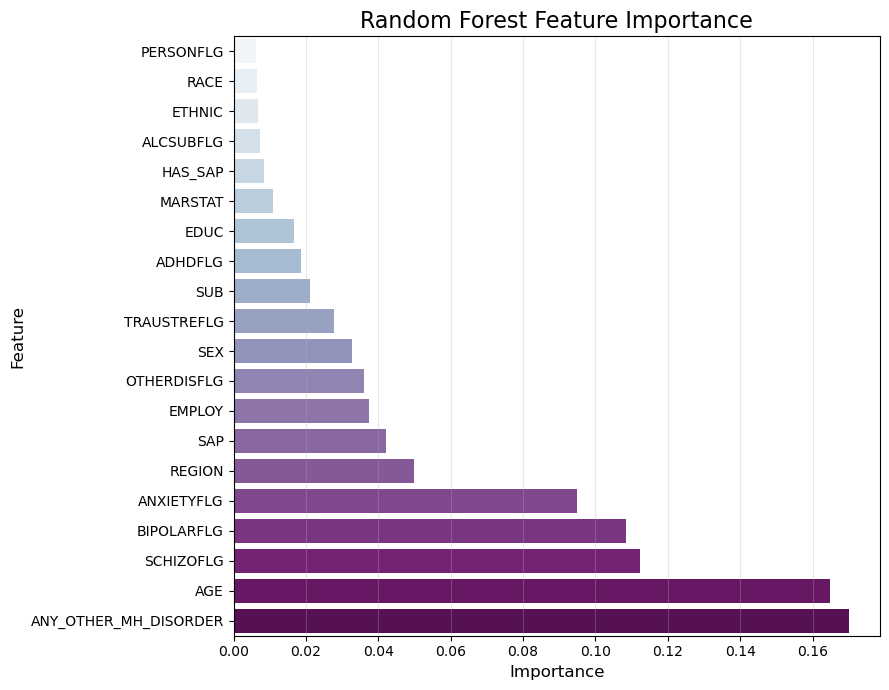

In [159]:
top = importances.head(20).sort_values()

plt.figure(figsize=(9, 7))
sns.barplot(
x=top.values,
y=top.index,
        palette="BuPu"
    )
plt.title("Random Forest Feature Importance", fontsize=16)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

#### LightGBM

/var/folders/y0/l_j_8m053y75mzd0tc31bl9h0000gn/T/ipykernel_63695/4184752902.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


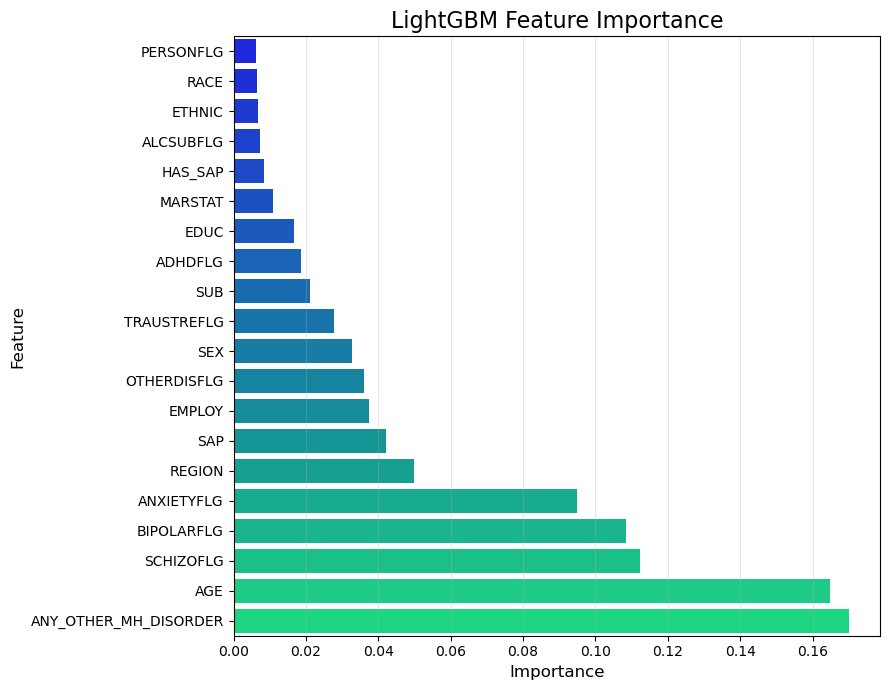

In [163]:
lgbm_importances = pd.Series(
    lgbm.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

top = importances.head(20).sort_values()

plt.figure(figsize=(9, 7))
sns.barplot(
        x=top.values,
        y=top.index,
        palette="winter"
    )

plt.title("LightGBM Feature Importance", fontsize=16)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

#### CatBoost

In [165]:
# Getting feature importance values from CatBoost model
cat_importances = cat.get_feature_importance(prettified=True)
print(cat_importances)

               Feature Id  Importances
0              ANXIETYFLG    16.709984
1             TRAUSTREFLG    12.769000
2              BIPOLARFLG     9.280313
3             OTHERDISFLG     8.873139
4                 ADHDFLG     8.400993
5   ANY_OTHER_MH_DISORDER     7.320281
6                     AGE     6.963146
7               SCHIZOFLG     5.607702
8                  REGION     4.884205
9                     SAP     3.126911
10              PERSONFLG     2.624088
11              ALCSUBFLG     2.083960
12                 EMPLOY     2.048844
13                 ODDFLG     1.733580
14                 PDDFLG     1.512187
15                    SUB     1.309663
16                   EDUC     1.108889
17                    SEX     0.746970
18                HAS_SAP     0.579906
19                   RACE     0.542647
20                 ETHNIC     0.500020
21             CONDUCTFLG     0.432144
22                MARSTAT     0.385424
23                LIVARAG     0.315620
24             IS_VETERAN

In [167]:
# Converting to pandas series
imp_series = pd.Series(
    cat_importances["Importances"].values,
    index=cat_importances["Feature Id"].values
).sort_values(ascending=True)

/var/folders/y0/l_j_8m053y75mzd0tc31bl9h0000gn/T/ipykernel_63695/1476501251.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


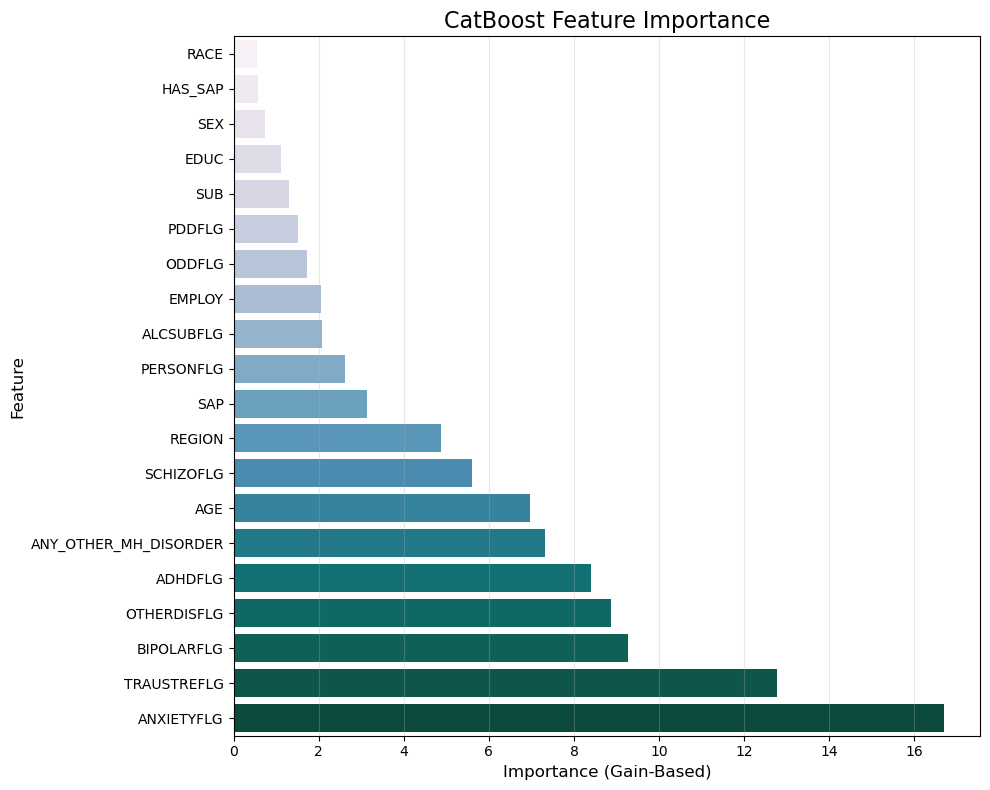

In [169]:
# Plotting top 20 most important features
top = imp_series.tail(20)

plt.figure(figsize=(10, 8))
sns.barplot(
    x=top.values,
    y=top.index,
    palette="PuBuGn"
)

plt.title("CatBoost Feature Importance", fontsize=16)
plt.xlabel("Importance (Gain-Based)", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

In [171]:
# Plotting bottom 20 features


### Feature Effects (SGD)

In [174]:
# Getting feature effects values from sgd model
sgd.named_steps["sgd"].coef_
sgd = sgd.named_steps["sgd"]

# Converting to pandas series
coefs = pd.Series(
    sgd.coef_[0],
    index=X_train.columns
).sort_values()

/var/folders/y0/l_j_8m053y75mzd0tc31bl9h0000gn/T/ipykernel_63695/203848772.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_pos.values, y=top_pos.index, palette="Blues")


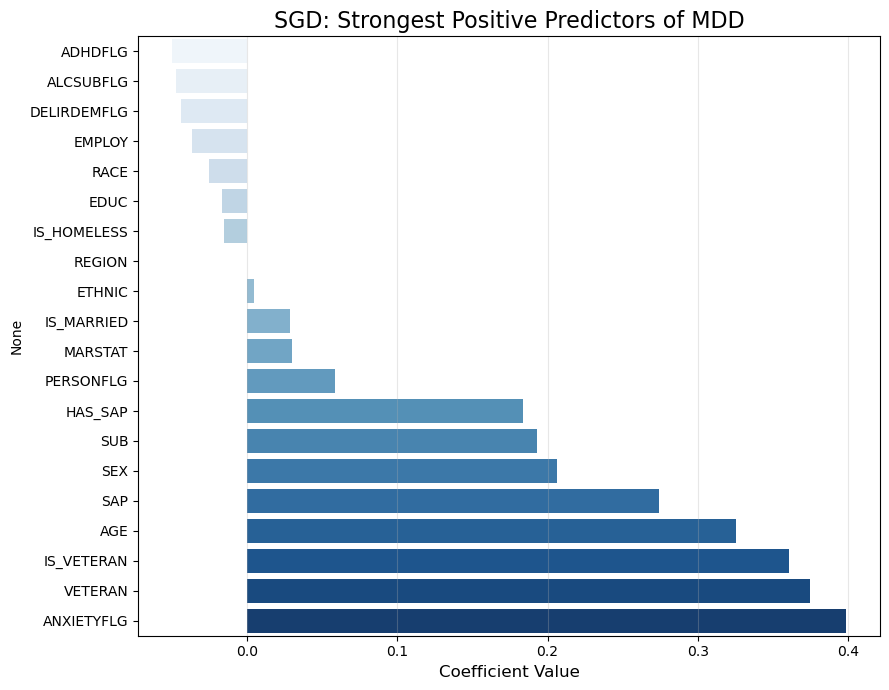

In [176]:
top_pos = coefs.tail(20).sort_values()

plt.figure(figsize=(9,7))
sns.barplot(x=top_pos.values, y=top_pos.index, palette="Blues")
plt.title("SGD: Strongest Positive Predictors of MDD", fontsize=16)
plt.xlabel("Coefficient Value", fontsize=12)
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

/var/folders/y0/l_j_8m053y75mzd0tc31bl9h0000gn/T/ipykernel_63695/1493180783.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_neg.values, y=top_neg.index, palette="Purples")


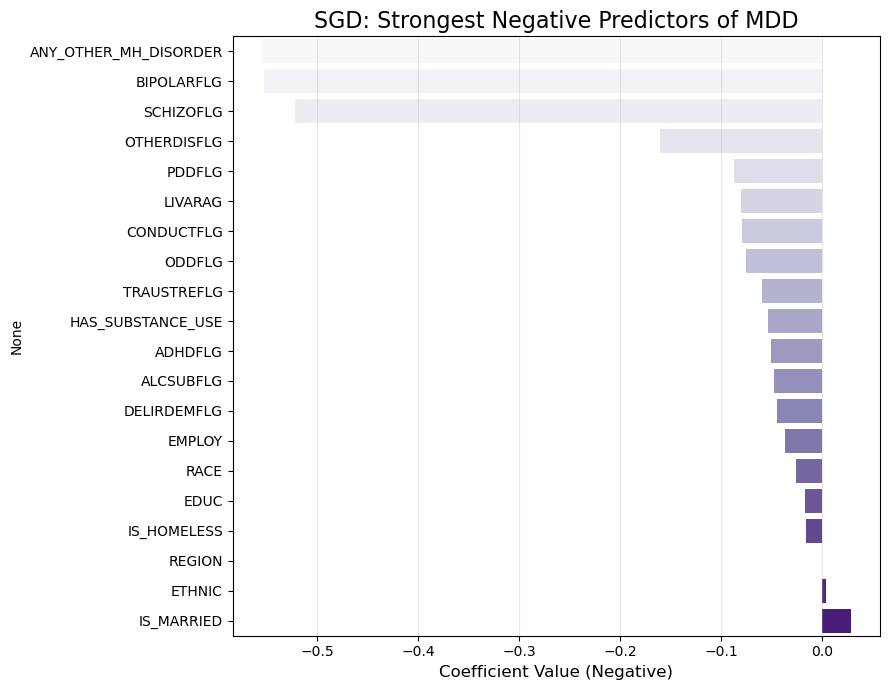

In [178]:
top_neg = coefs.head(20).sort_values()

plt.figure(figsize=(9,7))
sns.barplot(x=top_neg.values, y=top_neg.index, palette="Purples")
plt.title("SGD: Strongest Negative Predictors of MDD", fontsize=16)
plt.xlabel("Coefficient Value (Negative)", fontsize=12)
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()